In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import datetime
from wordcloud import WordCloud, STOPWORDS
import re
import time

import nltk
from nltk.corpus import stopwords
nltk.download("stopwords")

import warnings
warnings.filterwarnings("ignore")
sns.set(style="darkgrid")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\svden\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
df = pd.read_csv('data_for_nlp_2.csv')
df

url  \
0           https://ria.ru/20231021/ssha-1904417196.html   
1           https://ria.ru/20231021/ssha-1904417196.html   
2         https://ria.ru/20231021/bayden-1904394553.html   
3        https://ria.ru/20231021/vuchich-1904392917.html   
4         https://ria.ru/20231021/vybory-1904342166.html   
...                                                  ...   
47999  https://ria.ru/20230418/grazhdanstvo-186606879...   
48000  https://ria.ru/20230418/gosuslugi-1866068344.html   
48001  https://ria.ru/20230418/grazhdanstvo-186606643...   
48002  https://ria.ru/20230418/ekstremizm-1866065945....   
48003         https://ria.ru/20230418/ii-1866064554.html   

                                                    date  \
0      20:47 21.10.2023\n                            ...   
1      20:47 21.10.2023\n                            ...   
2      18:16 21.10.2023\n                            ...   
3      18:08 21.10.2023\n                            ...   
4      14:04 21.10.2023\n                            ...   
...                                                  ...   
47999                                   14:08 18.04.2023   
48000  14:05 18.04.2023\n                            ...   
48001  14:00 18.04.2023\n                            ...   
48002  13:57 18.04.2023\n                            ...   
48003                                   13:50 18.04.2023   

                                                   title  \
0      Глава МИД Венесуэлы назвал причину разрыва с США    
1      Глава МИД Венесуэлы назвал причину разрыва с США    
2      Байден заявил о планах США "построить новый ми...   
3      Вучич сообщил о тяжелом разговоре со странами ...   
4      Зюганов назвал возможную дату начала кампании ...   
...                                                  ...   
47999  Госдума одобрила поправку о получении ребенком...   
48000  Госдума приняла закон об оповещении иностранца...   
48001  Дума расширила список причин для лишения приоб...   
48002  ГД одобрила лишение приобретенного гражданства...   
48003  Шадаев оценил применение искусственного интелл...   

                                                subtitle   view     topic  \
0      Пинто: Венесуэла всегда хотела хороших отношен...  10180  politics   
1      Пинто: Венесуэла всегда хотела хороших отношен...  14783  politics   
2      Байден пообещал, что США построят человечеству...  58330  politics   
3      Вучич: разговор со странами Запада по вопросу ...  24997  politics   
4      Зюганов: кампания по выборам президента РФ мож...  20628  politics   
...                                                  ...    ...       ...   
47999  Госдума одобрила поправку о получении российск...   1616   society   
48000  Госдума приняла закон об оповещении иностранца...   1554   society   
48001  Госдума одобрила поправку о лишении приобретен...  13321   society   
48002  ГД одобрила поправку о лишении приобретенного ...    788   society   
48003  Шадаев: в умелых руках применение искусственно...    462   society   

                                                    text  
0      МИНСК, 21 окт - РИА Новости. Министр иностранн...  
1      МИНСК, 21 окт - РИА Новости. Министр иностранн...  
2      ВАШИНГТОН, 21 окт — РИА Новости. Человечеству ...  
3      БЕЛГРАД, 21 окт — РИА Новости. Президент Серби...  
4      РОЖДЕСТВЕНО (Московская область), 21 окт — РИА...  
...                                                  ...  
47999  МОСКВА, 18 апр – РИА Новости. Дума на пленарно...  
48000  МОСКВА, 18 апр - РИА Новости. Госдума на плена...  
48001  МОСКВА, 18 апр — РИА Новости. Госдума приняла ...  
48002  МОСКВА, 18 апр – РИА Новости. Госдума на плена...  
48003  МОСКВА. 18 апр - РИА Новости. Использование ис...  

[48004 rows x 7 columns]

In [5]:
df.shape

(48004, 7)

In [6]:
df.topic.value_counts()

economy           8825
politics          8041
world             8040
incidents         8040
society           7825
defense_safety    7233
Name: topic, dtype: int64

## Удалим все строки, содержащие NaN и являющиеся дубликатами

In [7]:
df.dropna(inplace=True)
df.drop_duplicates(inplace=True)
df.isnull().sum()

url         0
date        0
title       0
subtitle    0
view        0
topic       0
text        0
dtype: int64

## В датасете есть и дубликаты новостей по названию, удалим и их

In [8]:
duplicates_in_title = df.title.duplicated()
df = df[~duplicates_in_title]

## Новостей в топике incidents сильно больше, чем в остальных. Удалим излишек

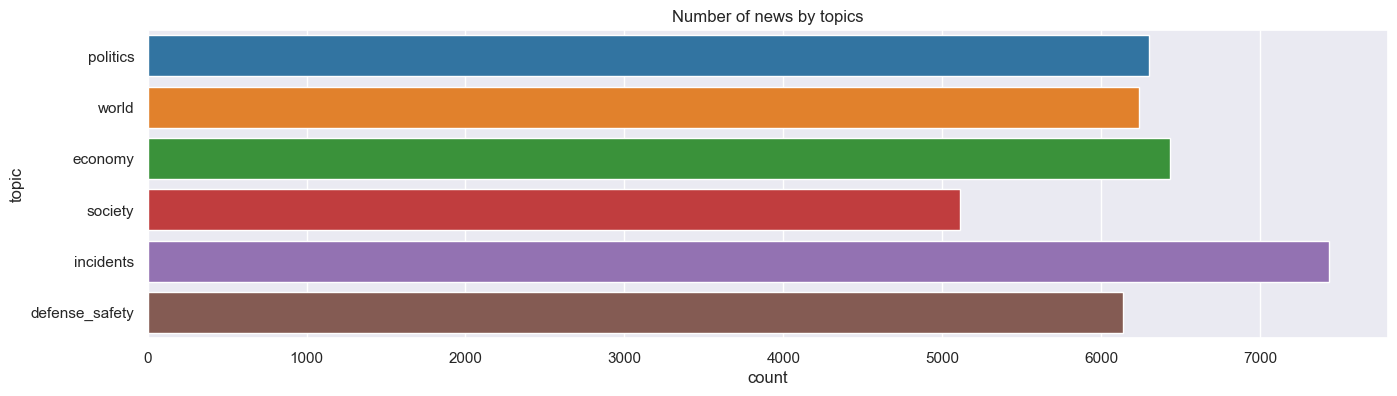

In [9]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16,4))
sns.countplot(y=df["topic"], palette='tab10', ax=ax)
plt.title('Number of news by topics');

## Удалим из топиков economy и defense_safety ~1500 объектов

In [10]:
mean_value_news_in_topics = df[df.topic != 'incidents'].topic.value_counts().mean()

value_news_in_incidents = df[df.topic == 'incidents'].shape[0]

index_to_drop_incidents = df[df.topic == 'incidents'].sample(int(value_news_in_incidents - mean_value_news_in_topics)).index

df.drop(index_to_drop_incidents, axis = 0, inplace=True)

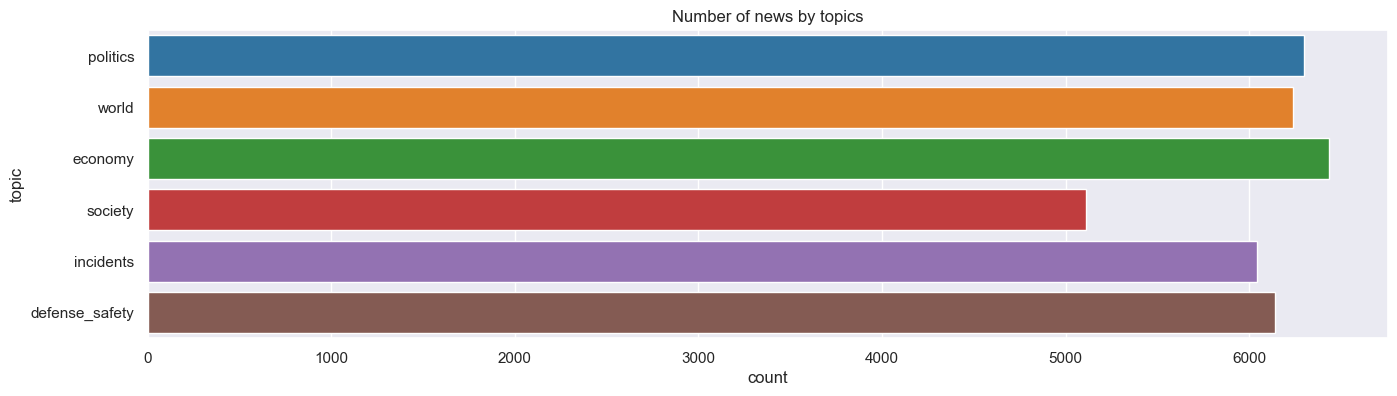

In [11]:
fig, ax = plt.subplots(1, 1, sharex=True, sharey=True, figsize=(16,4))
sns.countplot(y=df["topic"], palette='tab10', ax=ax)
plt.title('Number of news by topics');

## В колонке text присутствует специальный символ _/т_, удалим его


In [12]:
df.text = df.text.apply(lambda x: x.replace('\n', ''))

## Отформатируем столбцы view и date

In [13]:
df['view'] = df['view'].astype(int)
pattern = r'\d{2}:\d{2} \d{2}.\d{2}.\d{4}'
df['date'] = df['date'].apply(lambda x: re.match(pattern, x).group())
df['date'] = pd.to_datetime(df['date'])
df.head()

url                date  \
0      https://ria.ru/20231021/ssha-1904417196.html 2023-10-21 20:47:00   
2    https://ria.ru/20231021/bayden-1904394553.html 2023-10-21 18:16:00   
3   https://ria.ru/20231021/vuchich-1904392917.html 2023-10-21 18:08:00   
4    https://ria.ru/20231021/vybory-1904342166.html 2023-10-21 14:04:00   
5  https://ria.ru/20231020/kontakty-1904131418.html 2023-10-20 13:55:00   

                                               title  \
0  Глава МИД Венесуэлы назвал причину разрыва с США    
2  Байден заявил о планах США "построить новый ми...   
3  Вучич сообщил о тяжелом разговоре со странами ...   
4  Зюганов назвал возможную дату начала кампании ...   
5  В Кремле ответили на вопрос о контактах с США ...   

                                            subtitle   view     topic  \
0  Пинто: Венесуэла всегда хотела хороших отношен...  10180  politics   
2  Байден пообещал, что США построят человечеству...  58330  politics   
3  Вучич: разговор со странами Запада по вопросу ...  24997  politics   
4  Зюганов: кампания по выборам президента РФ мож...  20628  politics   
5  Песков: РФ и США не контактируют по Ближнему В...   4579  politics   

                                                text  
0  МИНСК, 21 окт - РИА Новости. Министр иностранн...  
2  ВАШИНГТОН, 21 окт — РИА Новости. Человечеству ...  
3  БЕЛГРАД, 21 окт — РИА Новости. Президент Серби...  
4  РОЖДЕСТВЕНО (Московская область), 21 окт — РИА...  
5  МОСКВА, 20 окт - РИА Новости. Россия и США не ...

## Создадим колонки с днем, месяцем и годом

In [14]:
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.strftime("%B")
df['weekday'] = df['date'].dt.strftime('%A')

- Подавляющее число новстей относится к 2023 года
- Больше всего новостей приходится на июнь, сентябрь и октябрь, меньше всего на декабрь, январь и февраль
- Больше всего новостей приходится на пятницу, меньше всего - на субботу и воскресенье

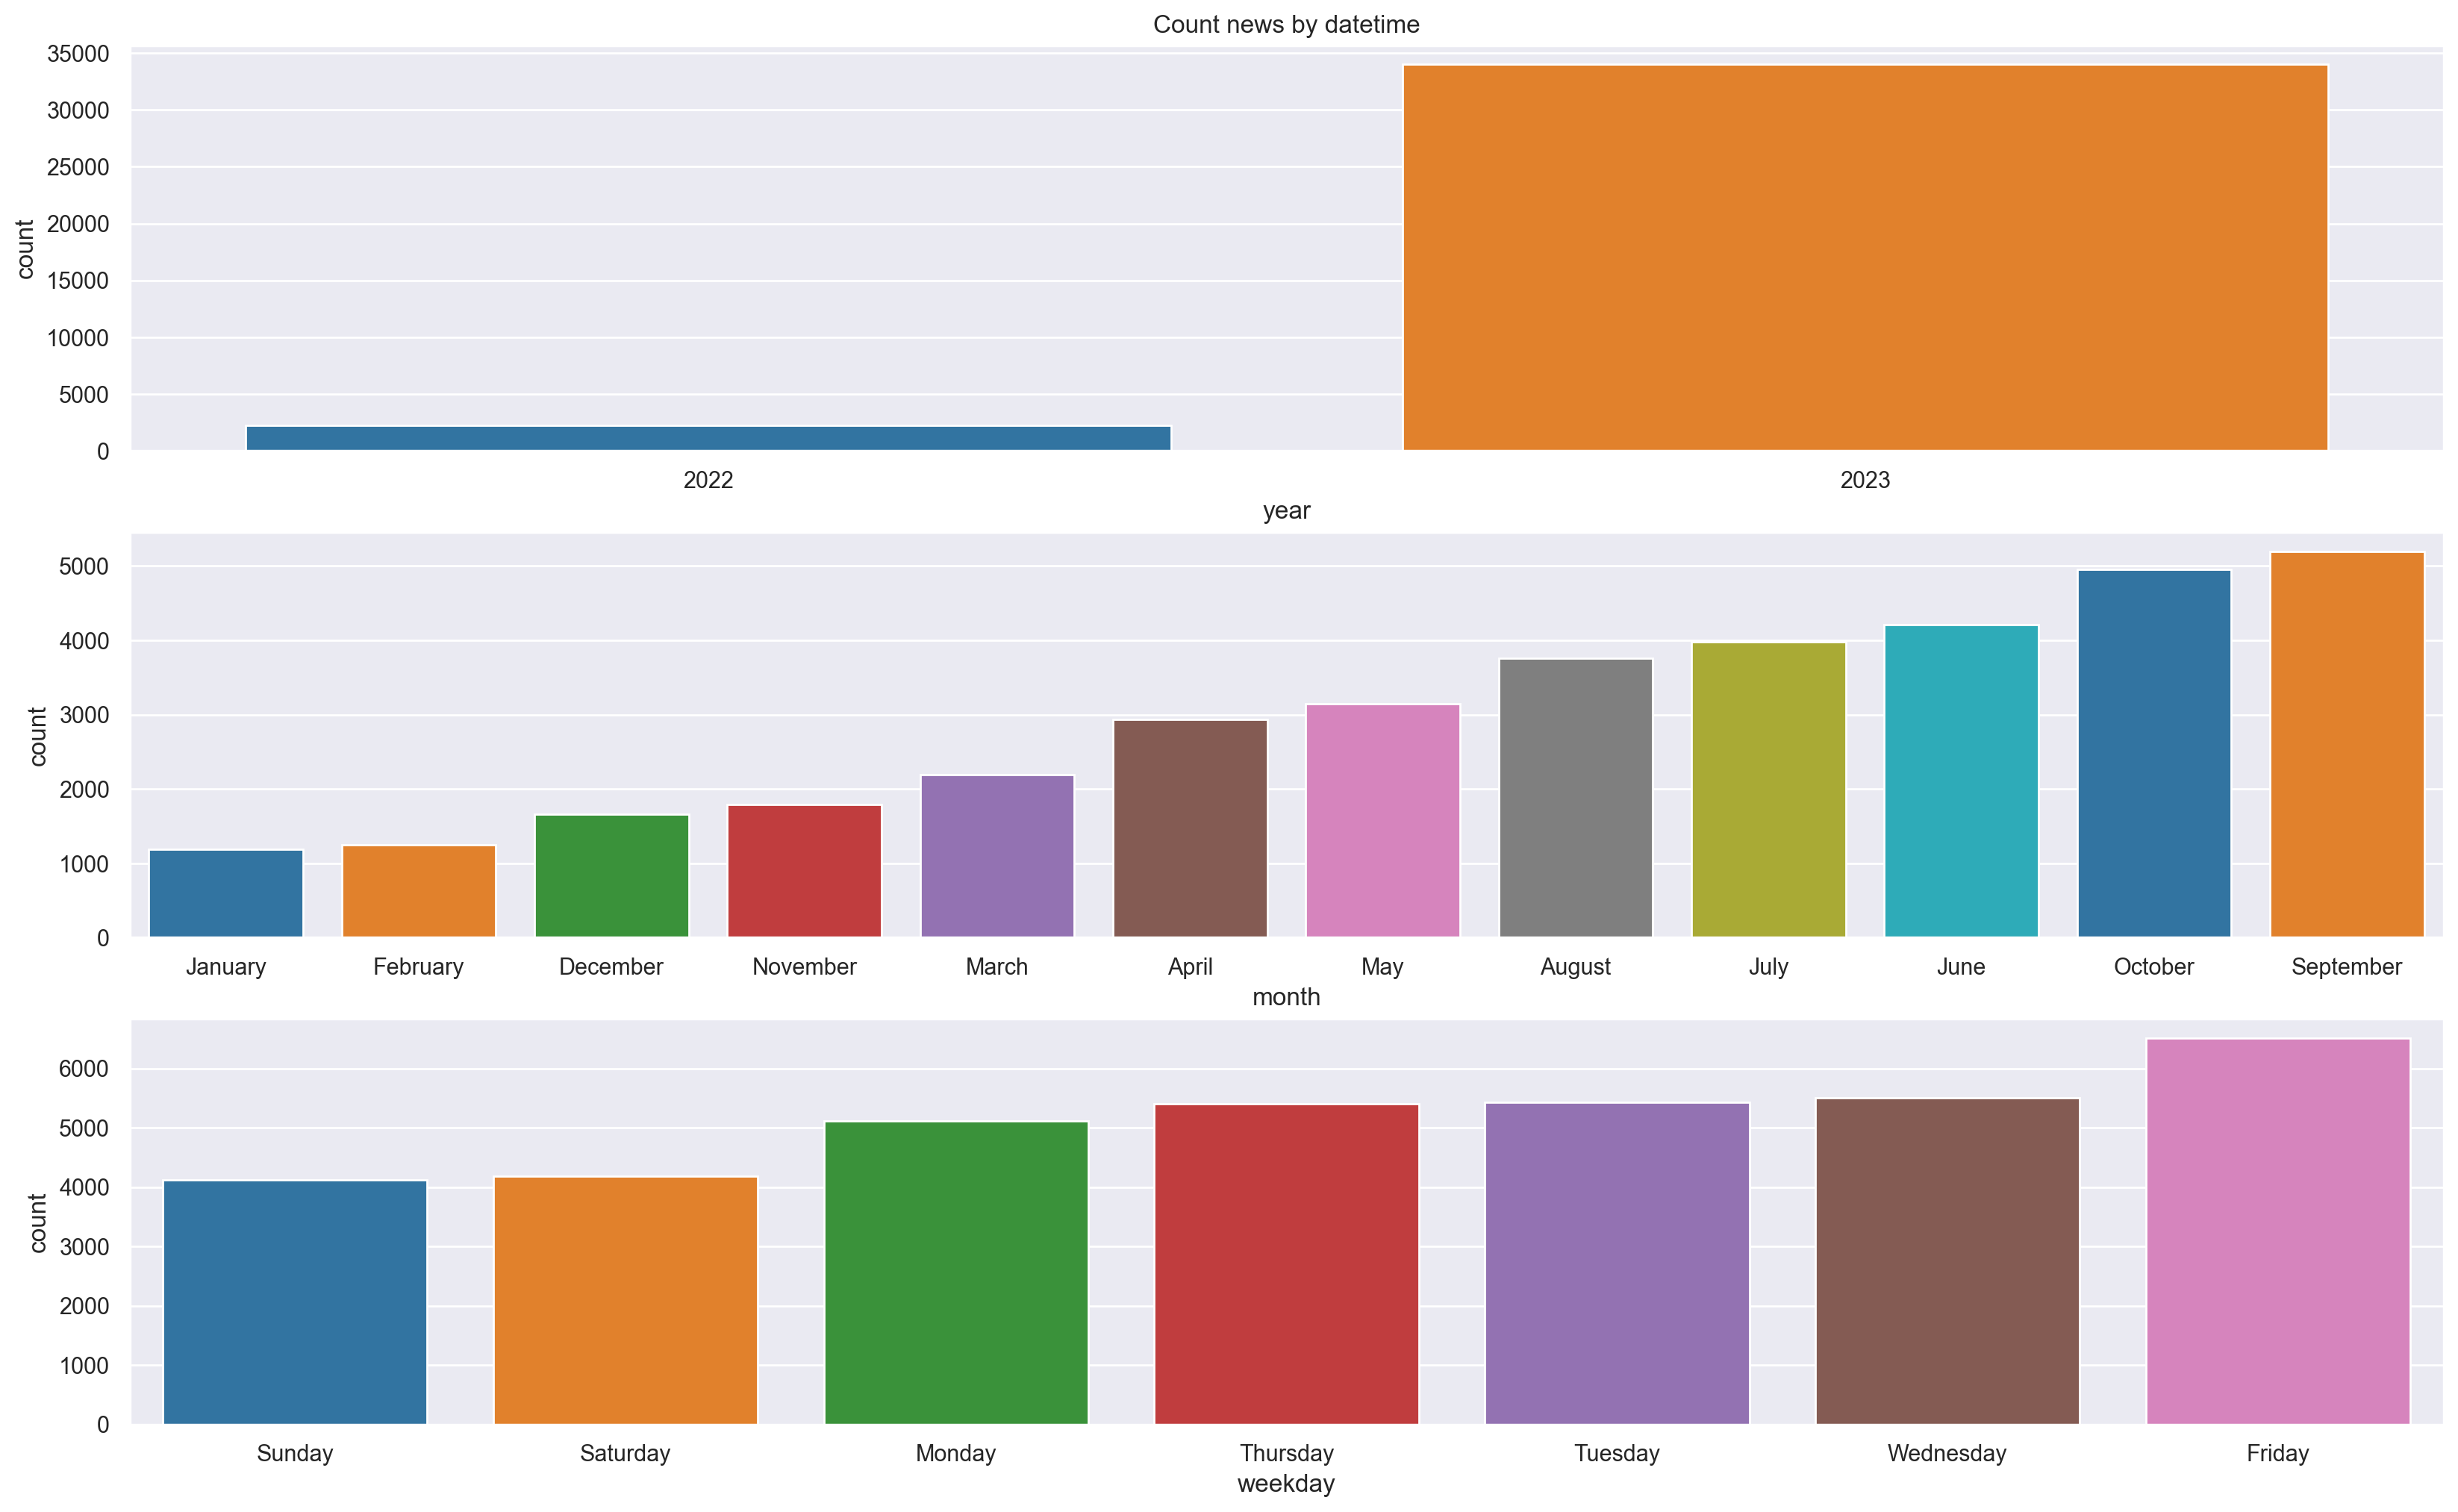

In [15]:
fig, axs = plt.subplots(3, 1, figsize=(20, 12), dpi=200)
for ind, col in enumerate(['year', 'month', 'weekday']):
    sns.countplot(x=df[col], palette='tab10', ax=axs[ind], order=df[col].value_counts(ascending=True).index)
axs[0].set_title('Count news by datetime');

# Посмотрим на распределение числа просмотров по каждой из тематик
- Имеются выбросы в каждой тематике, особенно много их в топике 'Политика'
- На многое должен влиять возраст статьи, так, например, новые статьи могли еще не набрать свое предельное число просмотров

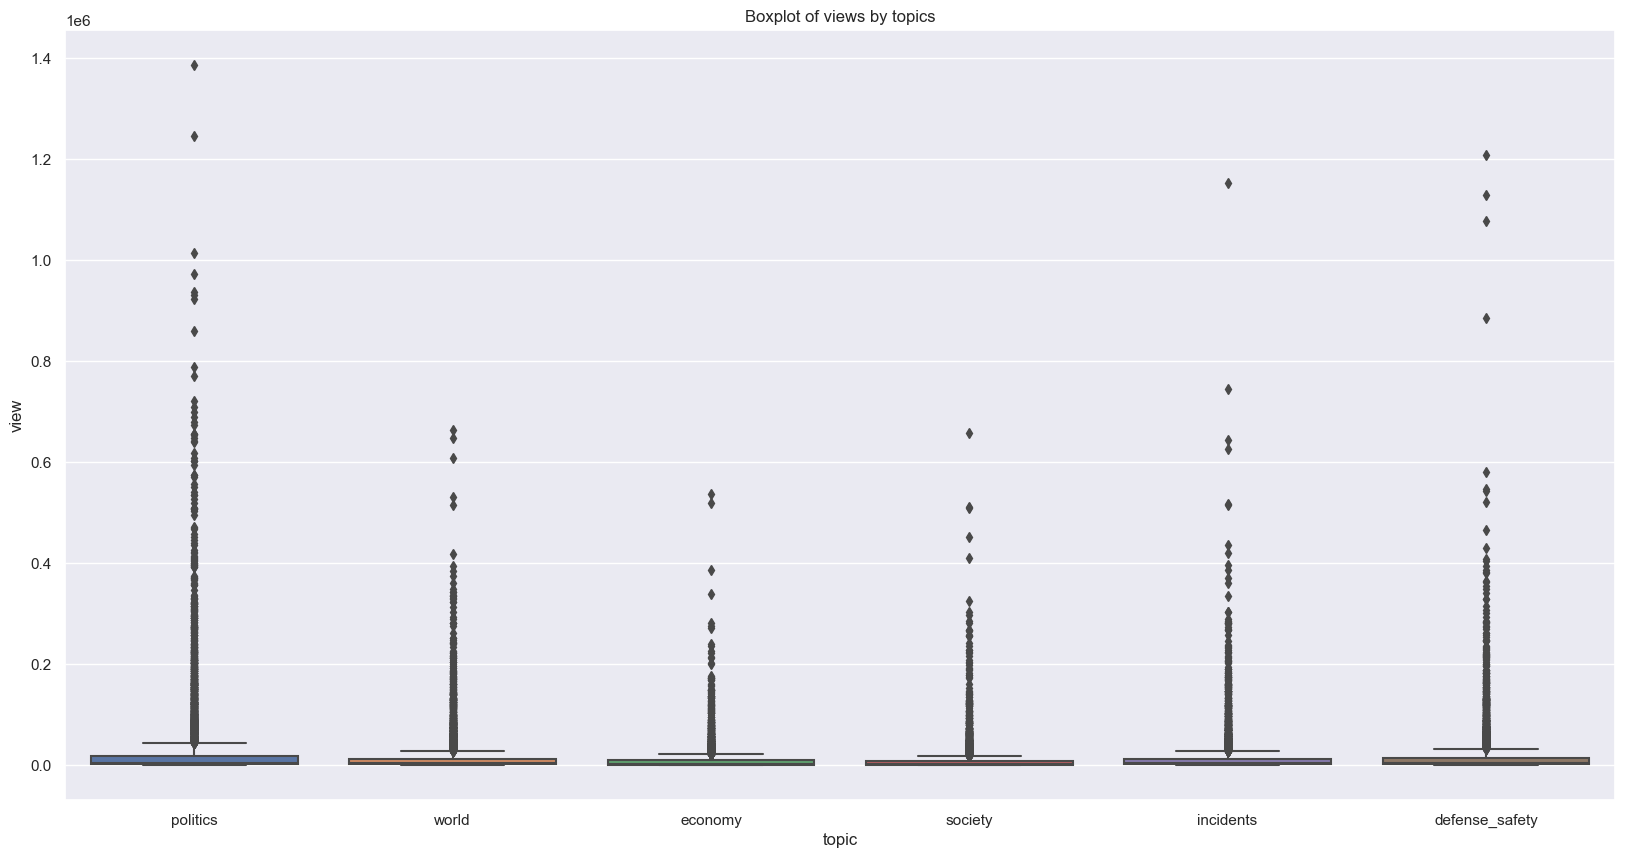

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
sns.boxplot(x="topic", y="view", data=df, ax=ax)
plt.title('Boxplot of views by topics');

## Рассмотрим в целом на распределение количества просмотров по всем данным
- Выделяются далекие выбросы
- Распределение похоже на логнормальное

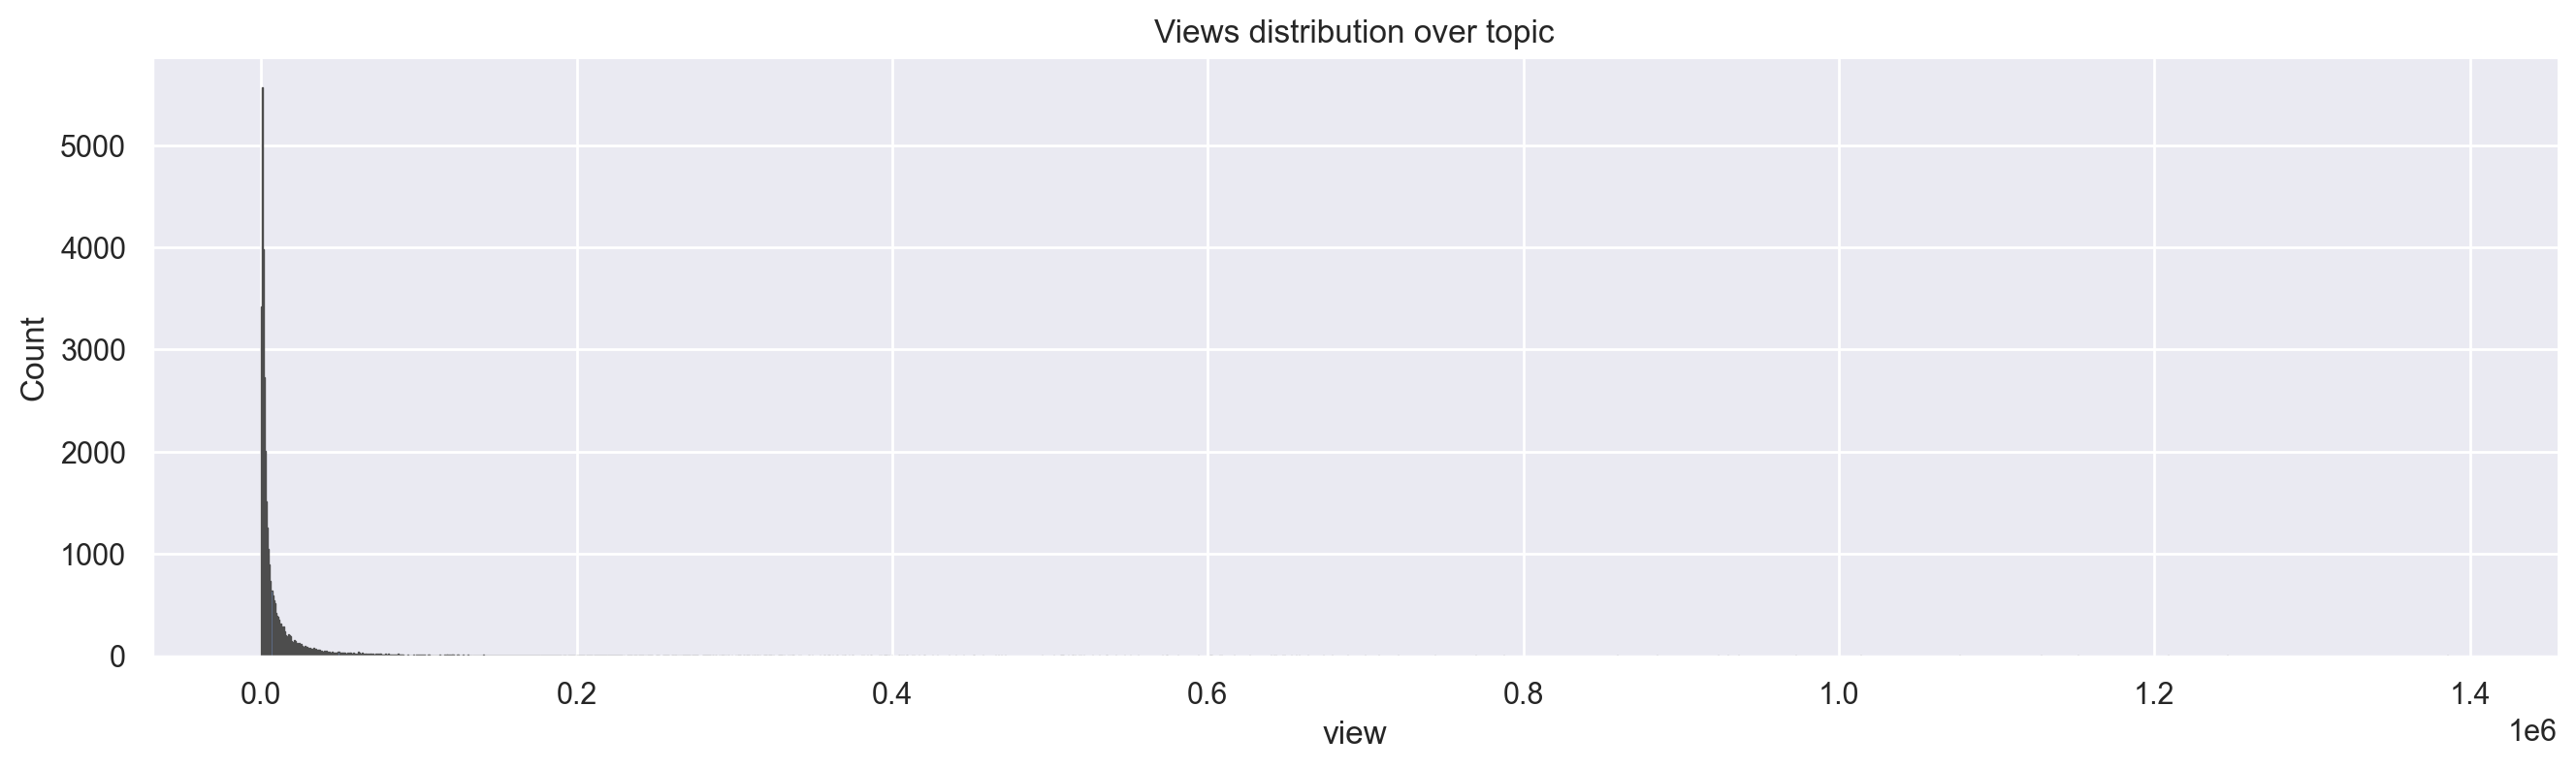

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(16, 4), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="view",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
);
axs.set_title('Views distribution over topic');

## Добавим признак - логарифм количества просмотров, сдвинутый на единицу

In [18]:
df['log_view'] = np.log1p(df['view'])

## На графике ниже по оси абсцисс отложен log1p количества просмотров, а по оси ординат - количество статей разных тематик, имеющих такое количество просмотров. Видно, что теперь распределение имеет форму, близкую к нормальному распределению, хоть оно немного скошено вправо и имеет отрицательный коэффициент асимметрии.

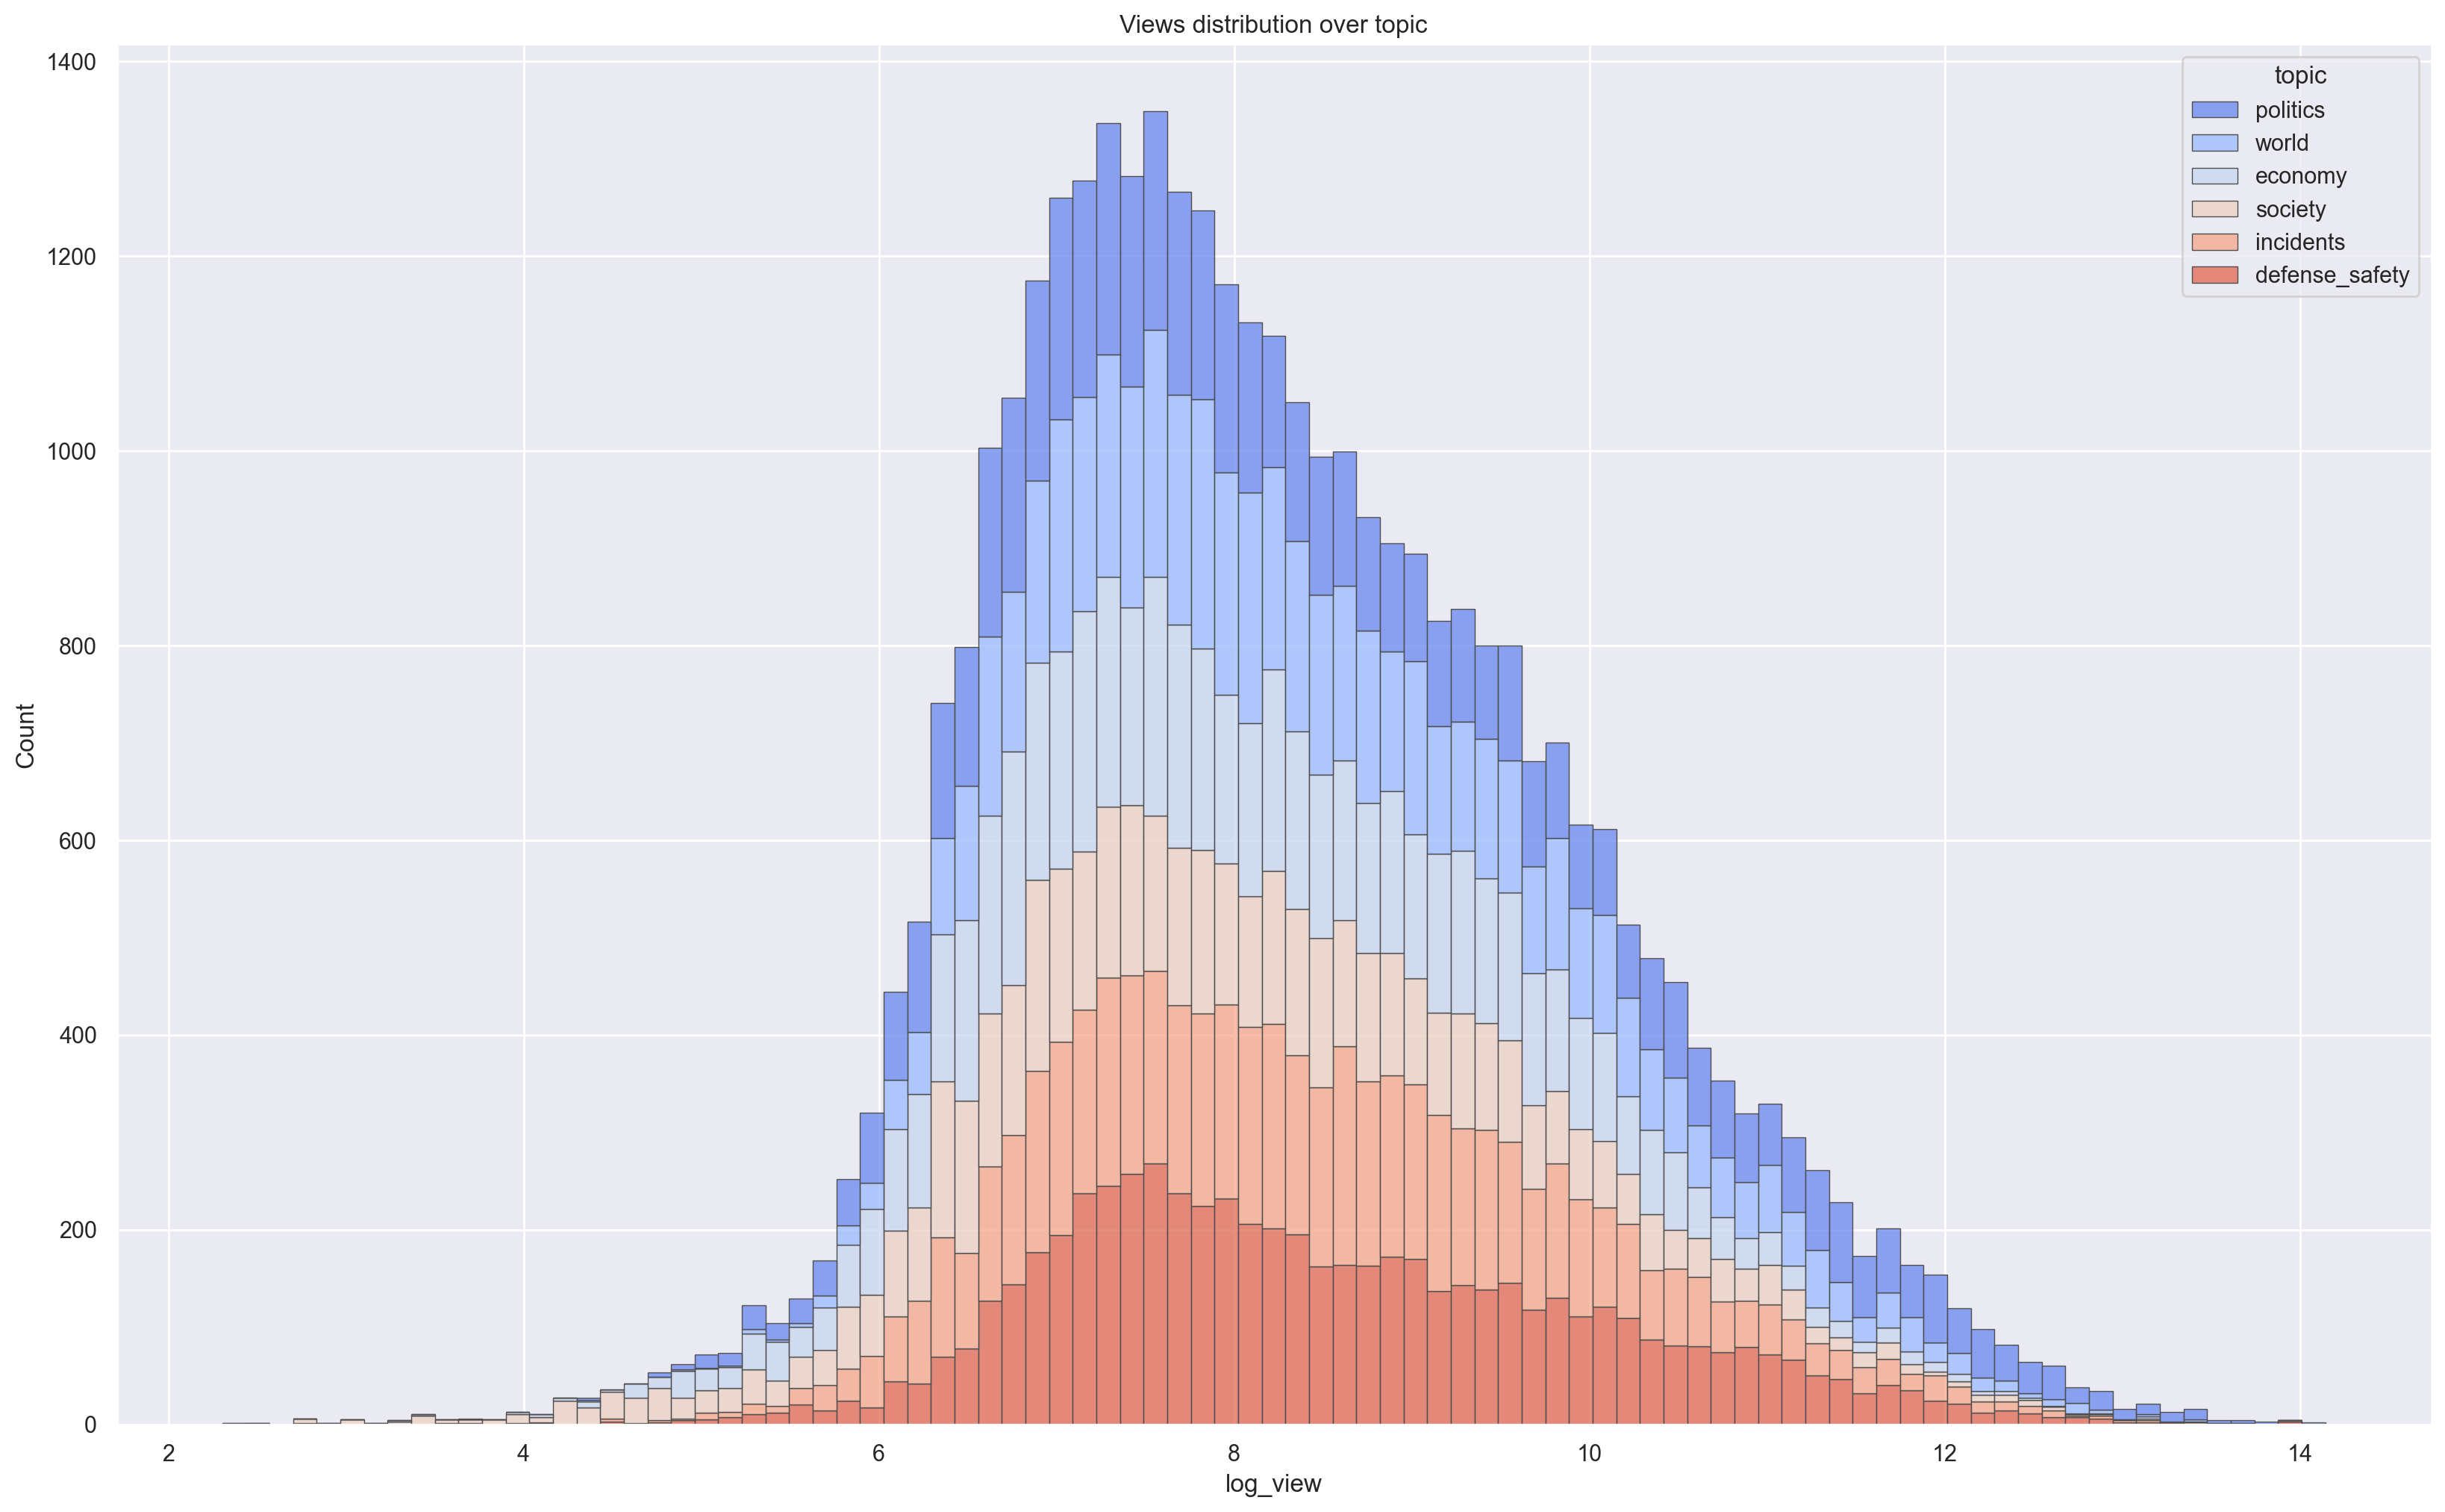

In [19]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="log_view",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
);
axs.set_title('Views distribution over topic');

## Воспользуемся критерием Манна-Уитни, чтобы проверить, насколько распределение просмотров близко к логнормальному.

In [20]:
from scipy.stats import mannwhitneyu

# Генерируем выборку из нормального распределения с таким же мат. ожиданием и дисперсией, как у нашей переменной
x = np.random.normal(loc=df['log_view'].mean(), scale=df['log_view'].std(), size=100000)

# Проводим тест Манна-Уитни и получаем p-значимость
U1, p = mannwhitneyu(x, df['log_view'])

print('P-значимость:', p)

# Возьмем границу принятия решения 1%
if p < 0.01:
    print('Распределение количества просмотров можно считать логнормальным')
else:
    print('Распределение количества просмотров нельзя считать логнормальным')

P-значимость: 1.9871928965351085e-14
Распределение количества просмотров можно считать логнормальным


## Посчитаем длину заголовков и основного текста

In [21]:
df['len_title'] = df['title'].str.len()
df['len_subtitle'] = df['subtitle'].str.len()
df['len_text'] = df['text'].str.len()

## Посмотрим, как выглядят заголовок и текст новости в разрезе каждой категории
- Длинна заголовка новости в среднем - 65 символов
- Длинна второго заголовка несколько длиннее - 78-85 символов
- Длинна текста имеет большие выбросы по темам: политика, общество, экономика

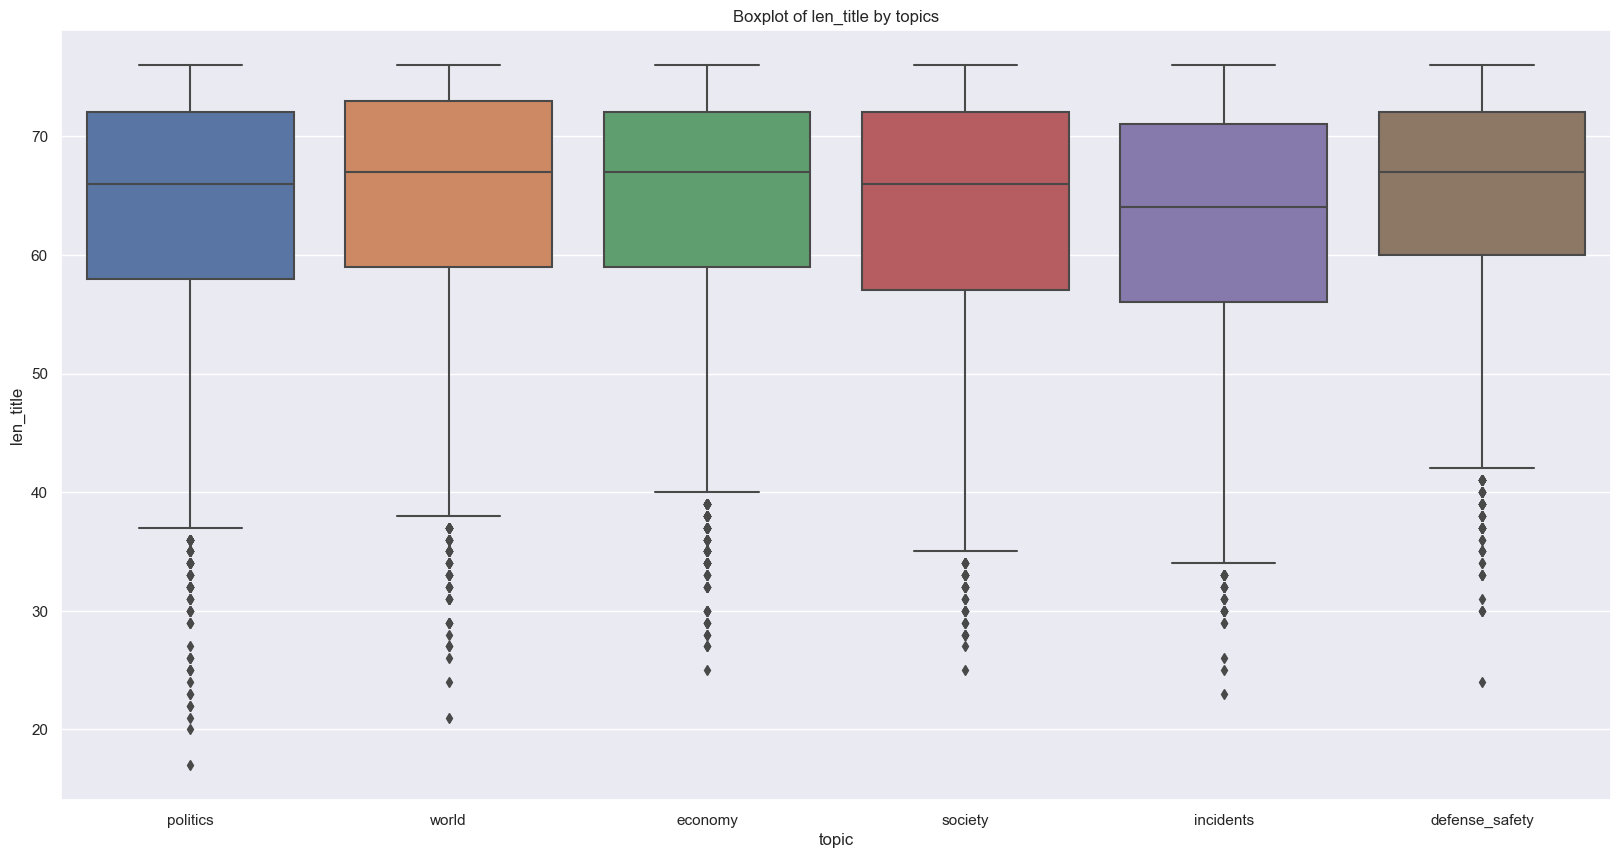

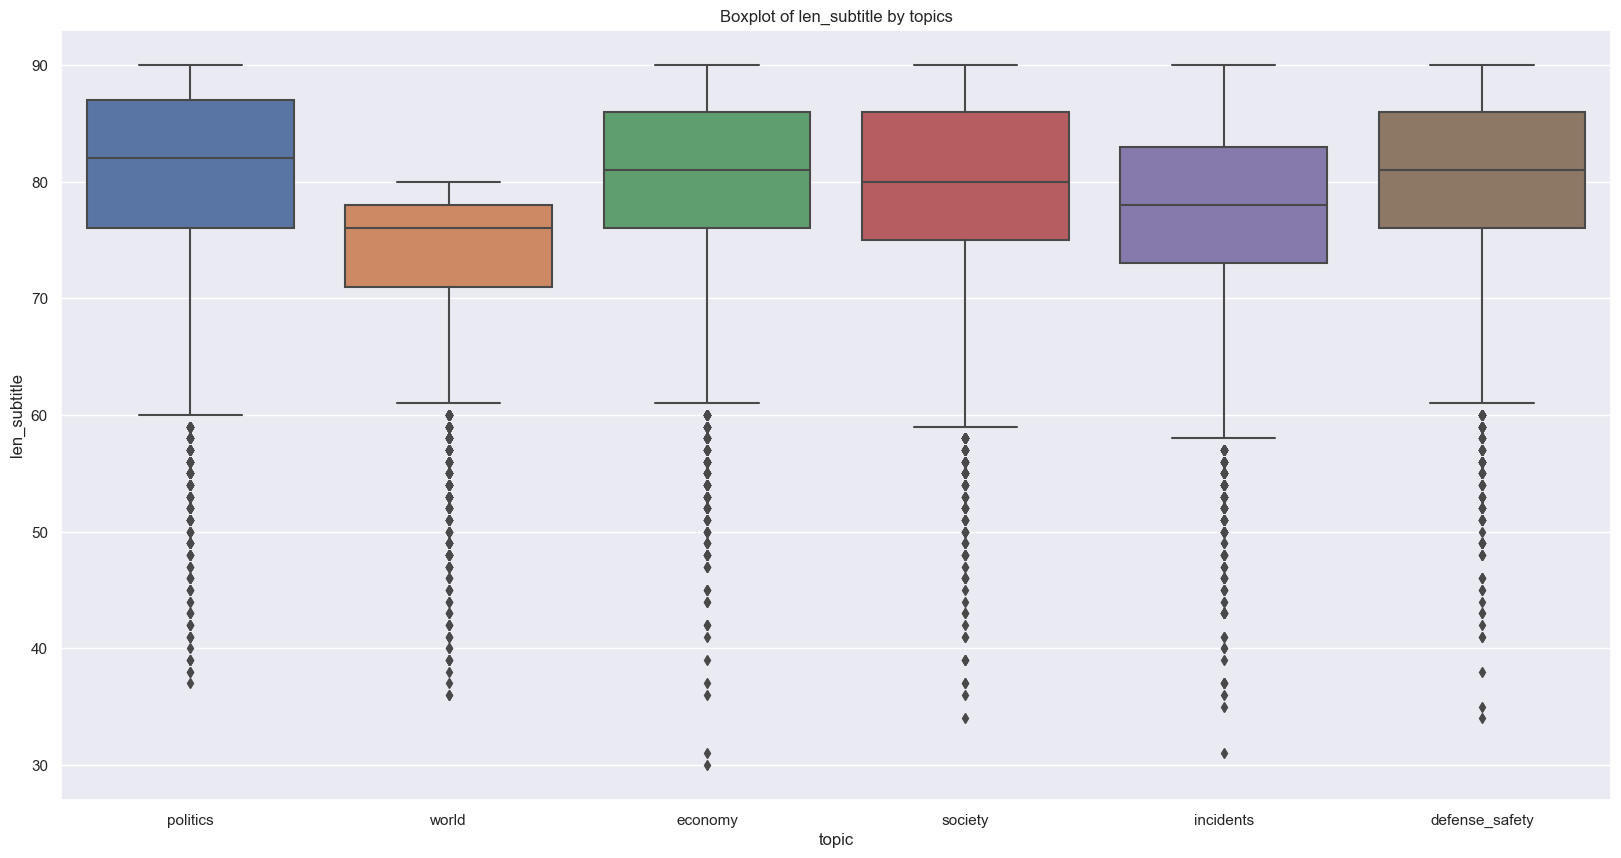

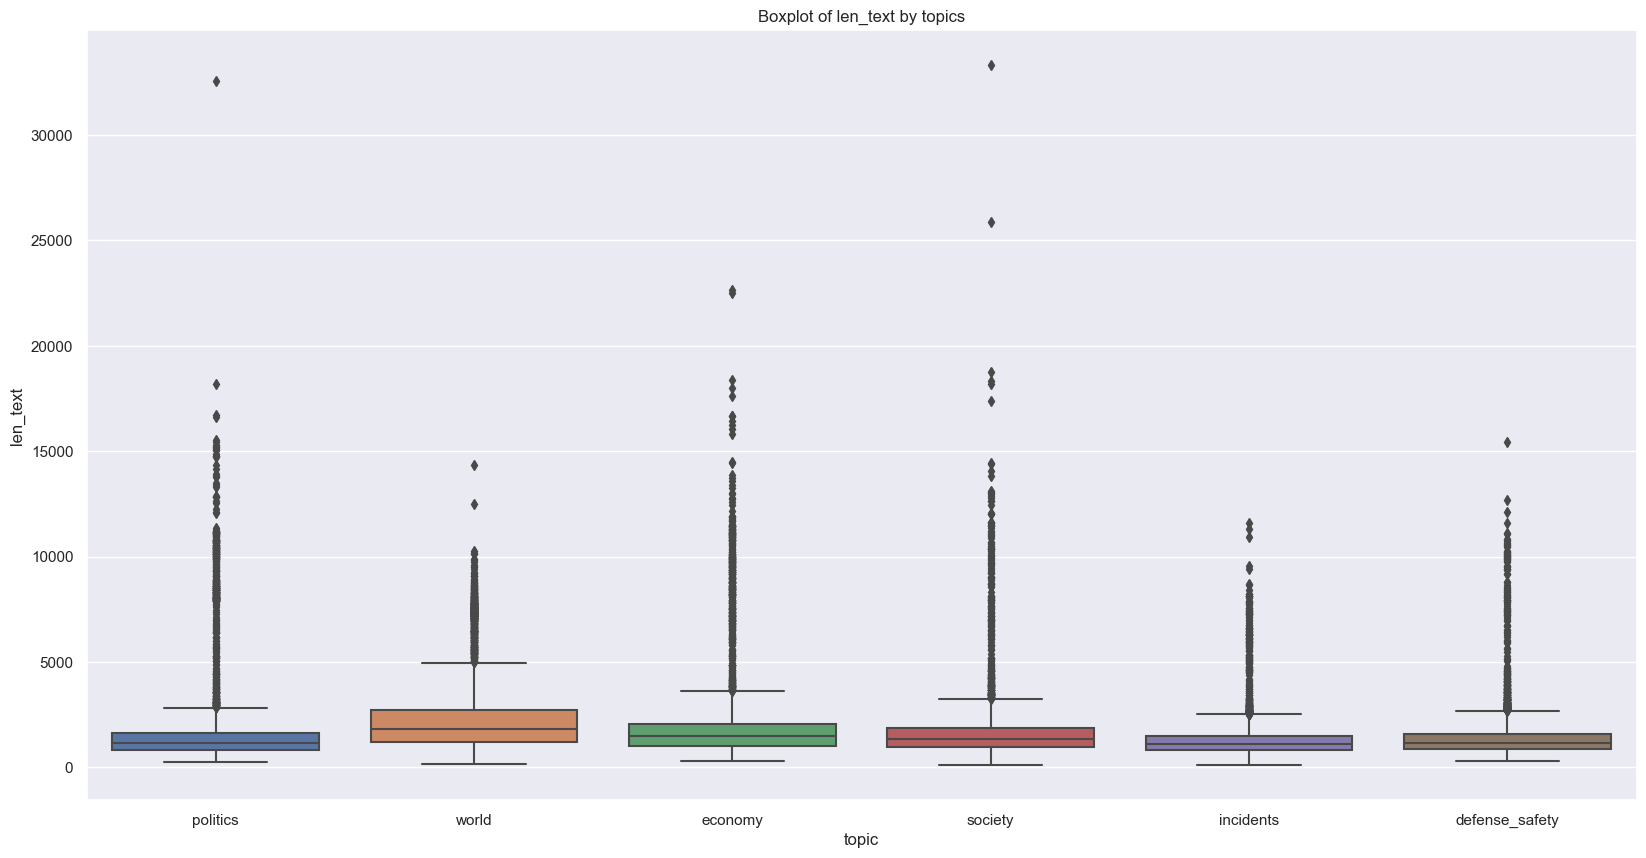

In [22]:
for col in ['len_title', 'len_subtitle', 'len_text']:
    fig, ax = plt.subplots(1, 1, figsize=(20, 10), dpi=100)
    sns.boxplot(x="topic", y=col, data=df, ax=ax)
    plt.title(f'Boxplot of {col} by topics');

# Посмотрим, какие ключевые слова чаще всего встречаются в статьях каждой тематики. Одной из гипотез является то, что статьи разных, но при этом близких тематик с одинаковыми ключевыми словами могут вносить негативный вклад в работу модели.

In [25]:
stop_words = stopwords.words('russian')
stop_words.extend(['что', 'это', 'так',
                    'вот', 'быть', 'как',
                    'в', '—', 'к', 'за', 'из', 'из-за',
                    'на', 'ок', 'кстати',
                    'который', 'мочь', 'весь',
                    'еще', 'также', 'свой',
                    'ещё', 'самый', 'ул', 'комментарий',
                    'английский', 'язык', 'заявил', 'заявили'])
# stop_words = []

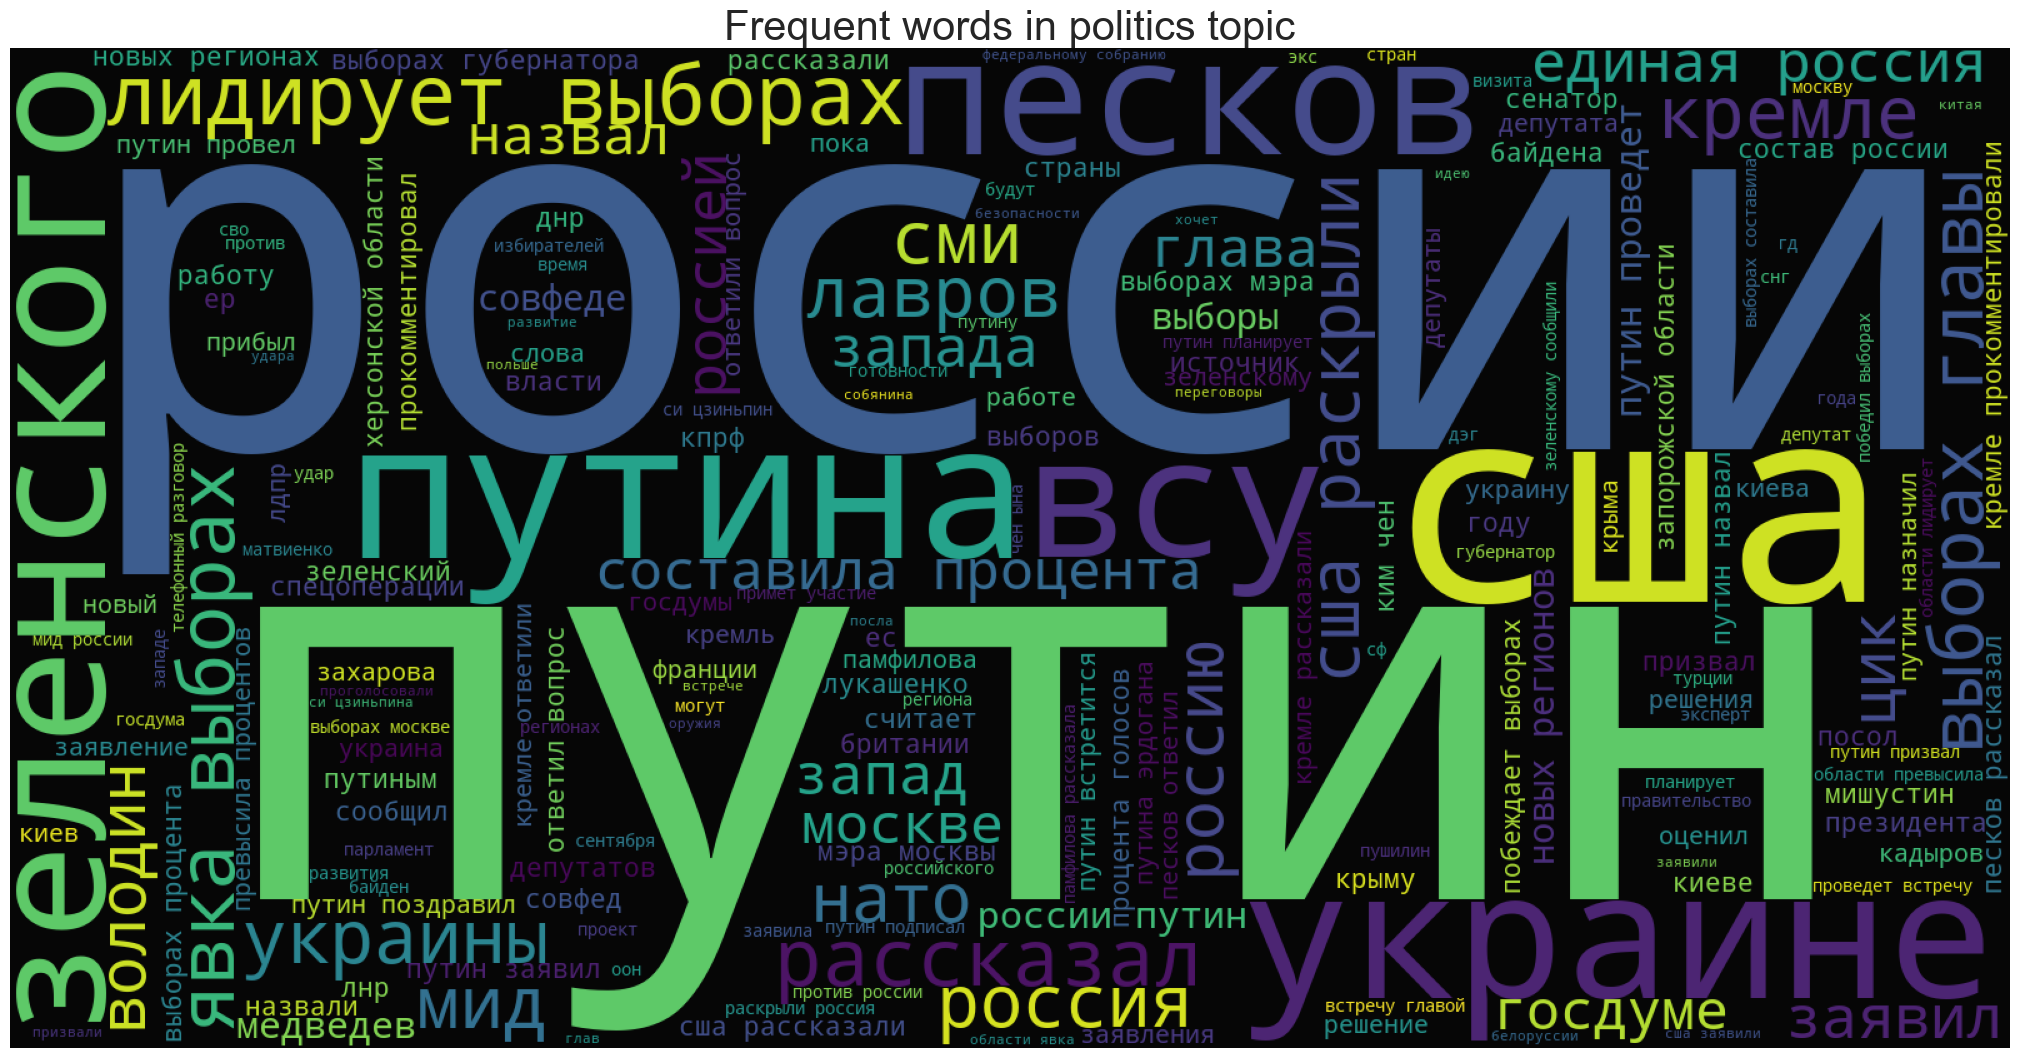

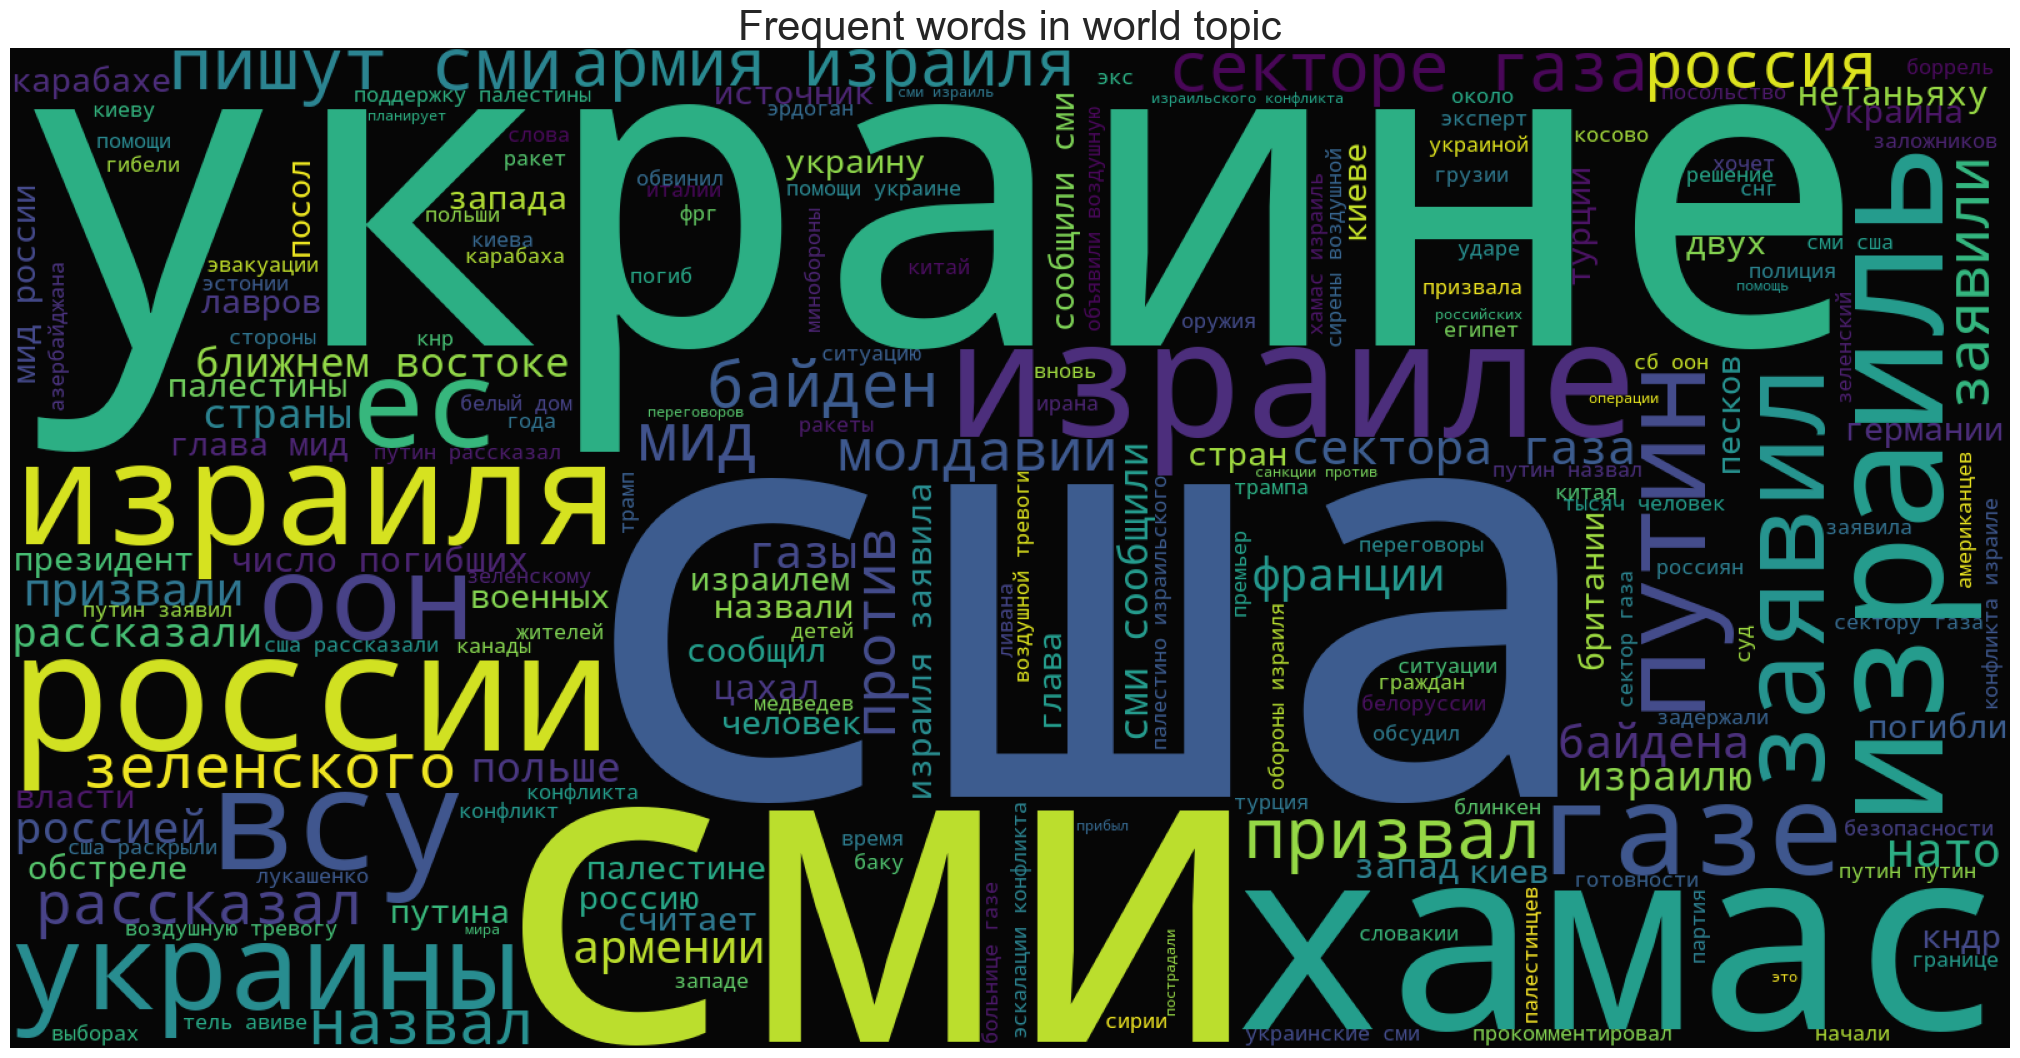

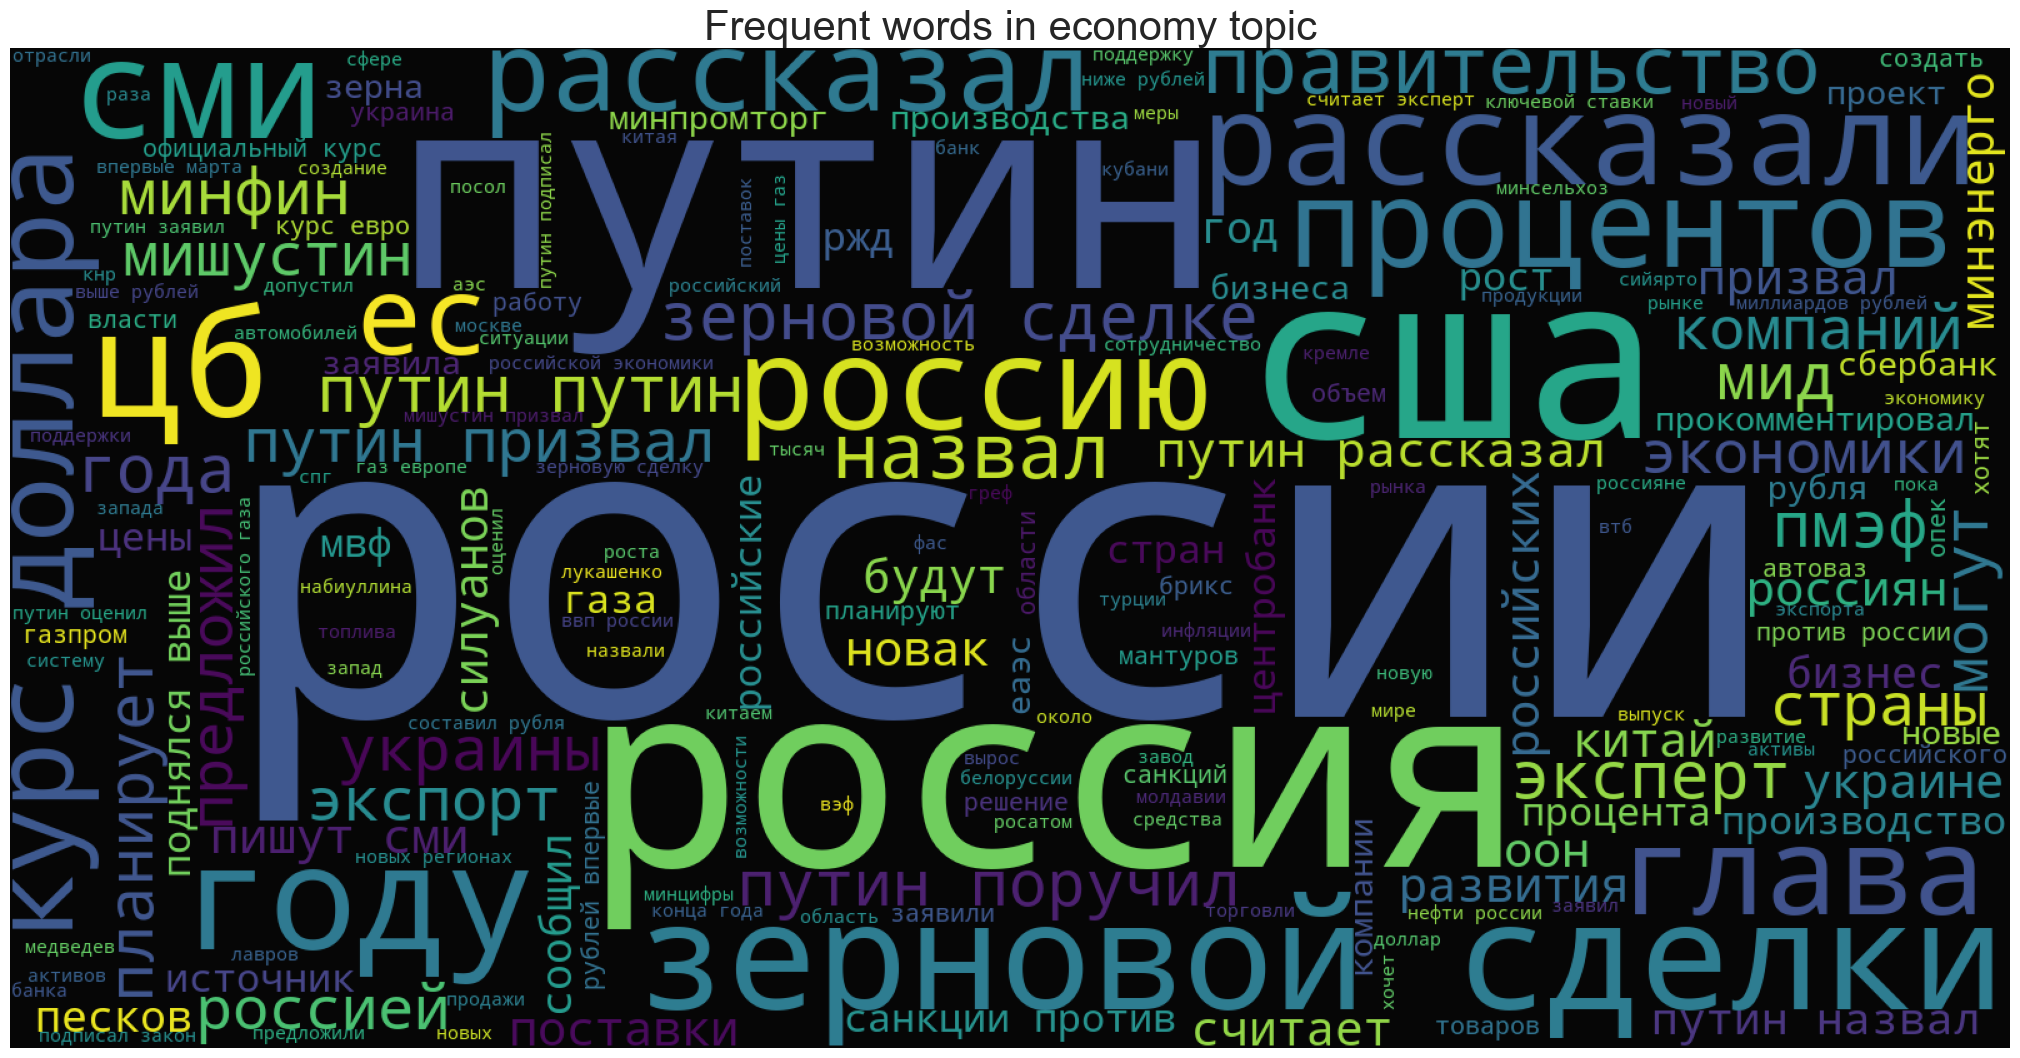

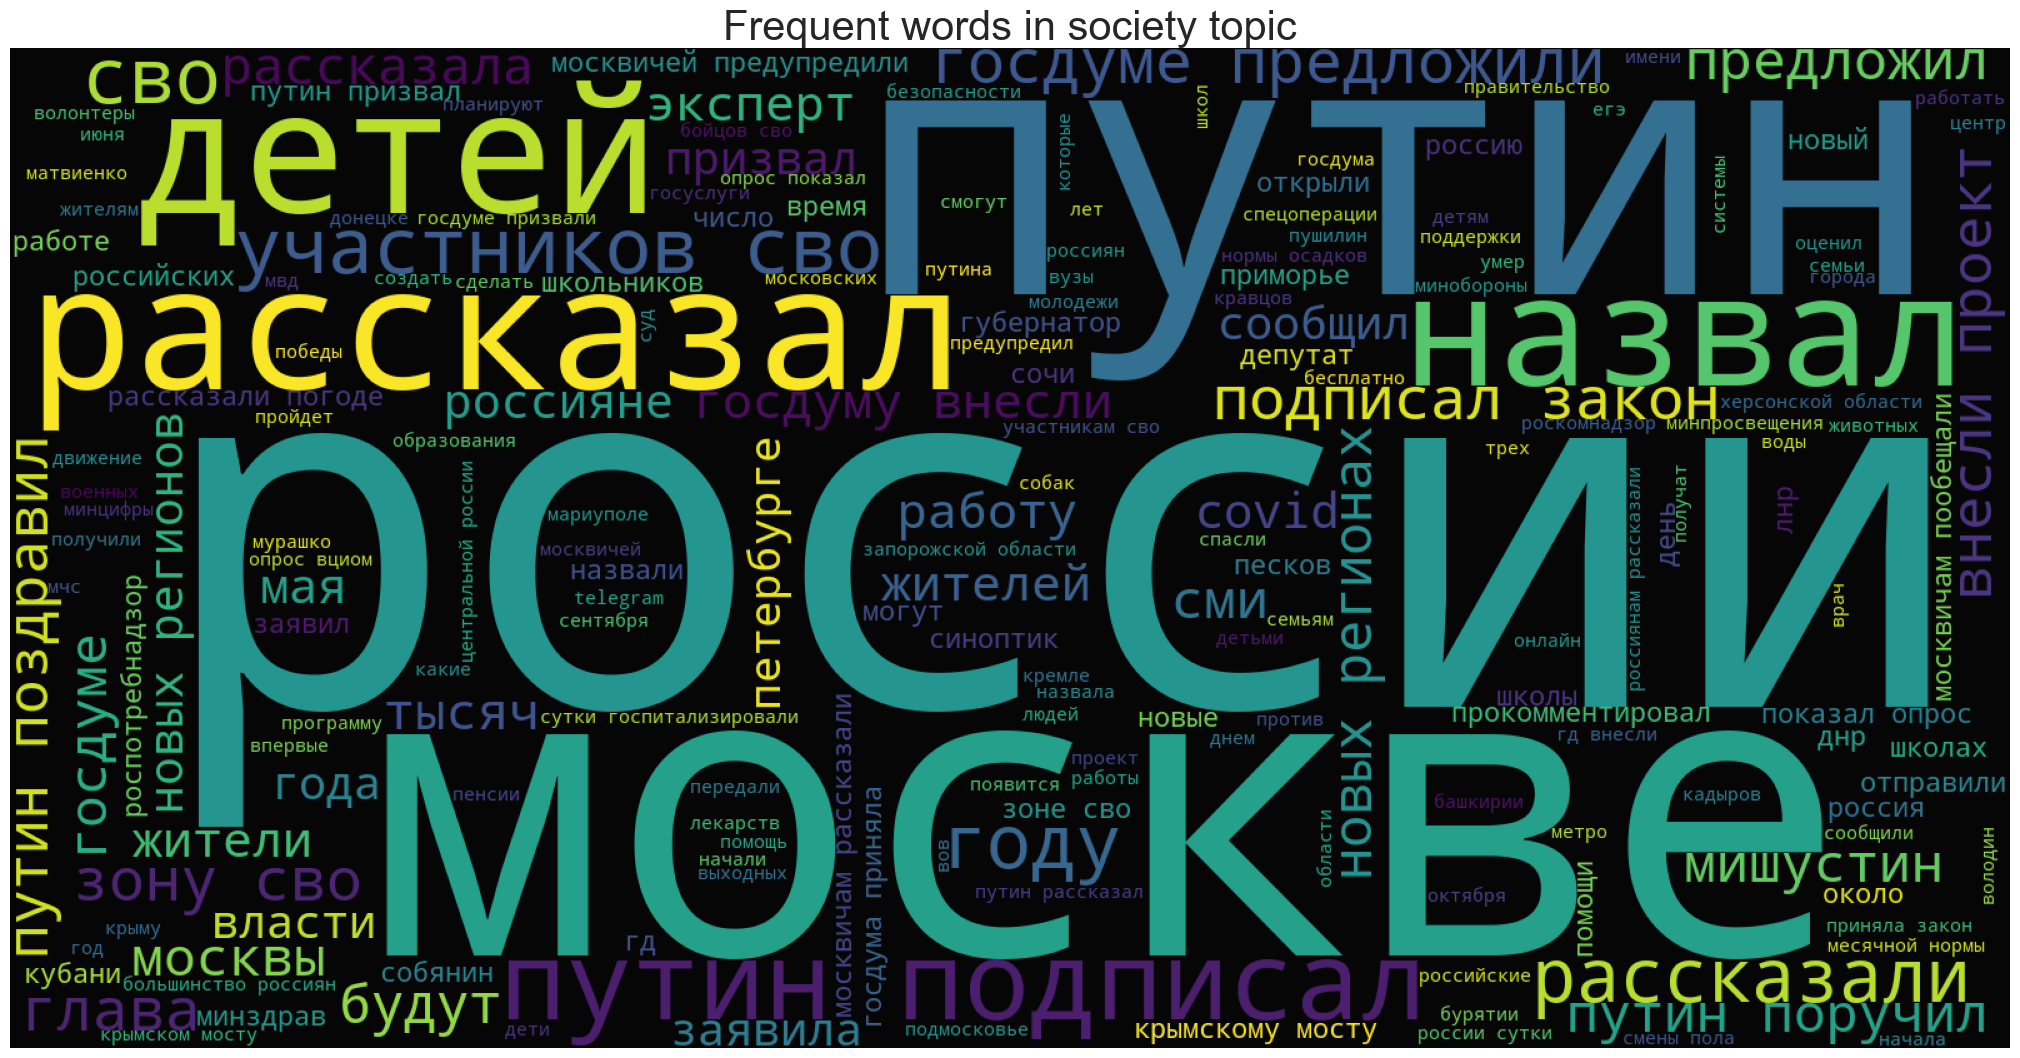

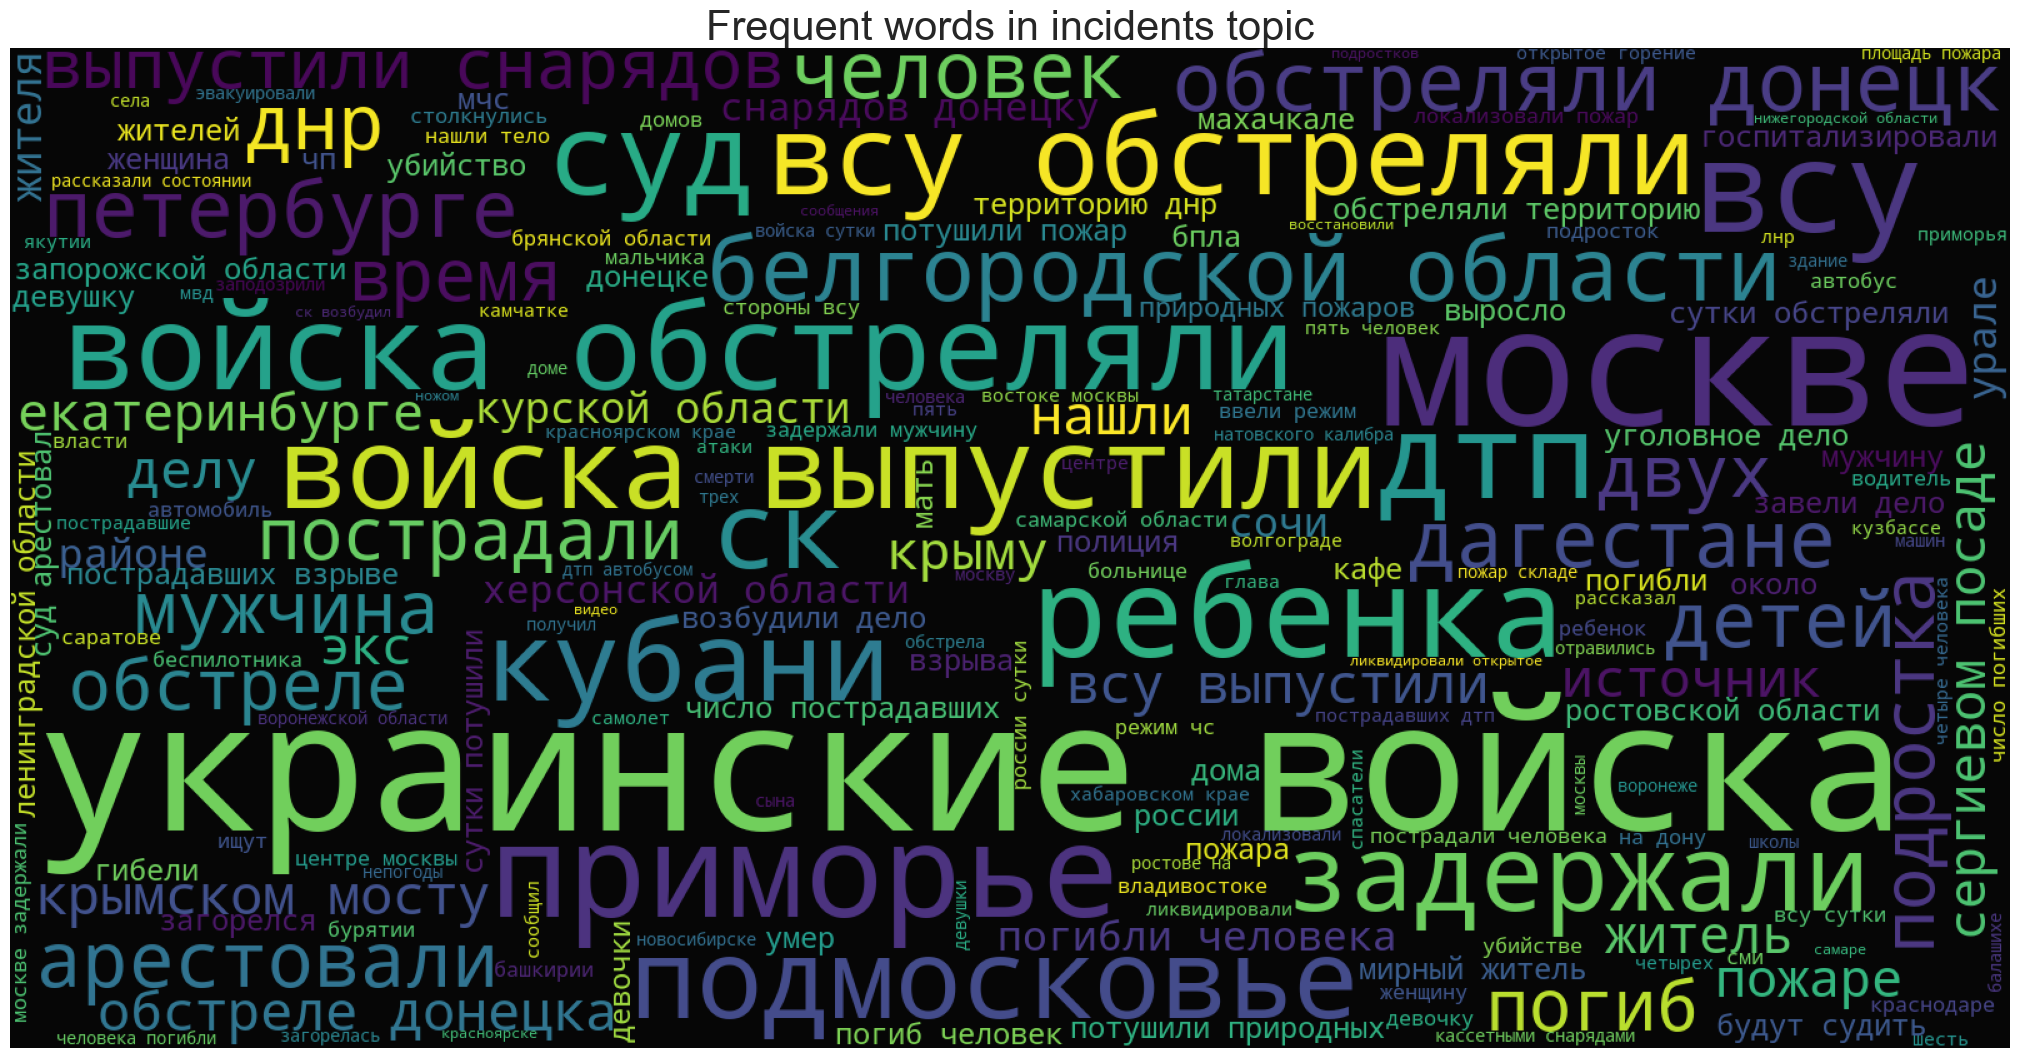

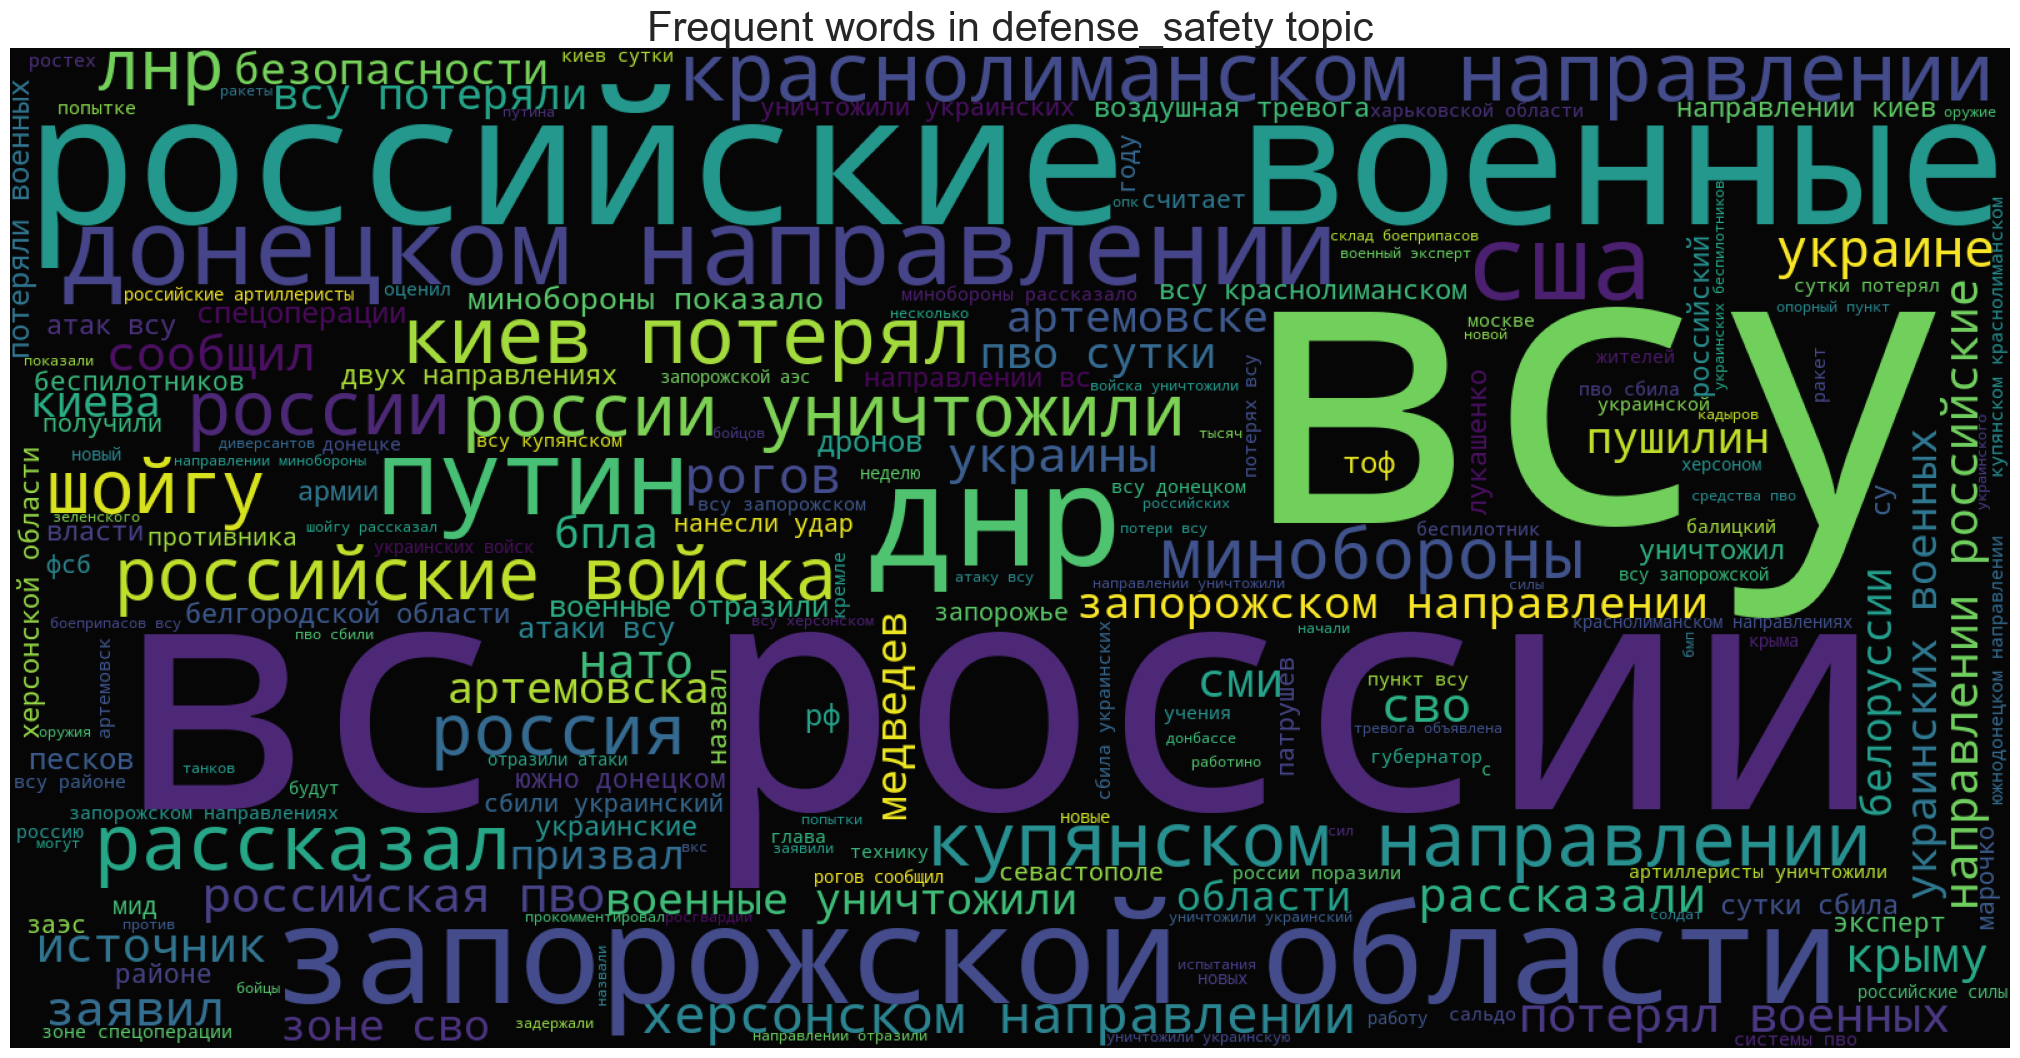

In [26]:
for topic in df.topic.unique():
    words = df[df.topic == topic].title.str.split(' ').explode().values
    words = [word.lower() for word in words if word.lower() not in stop_words]

    wc = WordCloud(background_color="black", width=1600, height=800)
    wc.generate(" ".join(words))

    fig, ax = plt.subplots(1, 1, figsize=(20, 10))
    plt.axis("off")
    plt.tight_layout(pad=0)
    ax.set_title(f"Frequent words in {topic} topic", fontsize=30)
    ax.imshow(wc, alpha=0.98)

In [27]:
df.sort_values(['view'], ascending=False)

url                date  \
4556     https://ria.ru/20230204/ukraina-1849762413.html 2023-04-02 17:31:00   
6691   https://ria.ru/20220930/zelenskiy-1820736517.html 2022-09-30 19:37:00   
37422     https://ria.ru/20230624/vagner-1880176884.html 2023-06-24 13:51:00   
33415  https://ria.ru/20230624/surovikin-1880110299.html 2023-06-24 00:50:00   
37364  https://ria.ru/20230624/prigozhin-1880247119.html 2023-06-24 20:28:00   
...                                                  ...                 ...   
47652  https://ria.ru/20230426/spetsoperatsiya-187026... 2023-04-26 07:34:00   
47921  https://ria.ru/20230419/gumpomosch-1870203970.... 2023-04-19 21:41:00   
47567    https://ria.ru/20230428/pomosch-1870271744.html 2023-04-28 08:53:00   
47687  https://ria.ru/20230425/spetsoperatsiya-187026... 2023-04-25 12:21:00   
17643  https://ria.ru/20230911/lokalizatsiya-18960315... 2023-11-09 10:57:00   

                                                   title  \
4556   "Путин принял решение". Зеленскому сообщили "у...   
6691   "Заткнись". Британцы пришли в ярость из-за сло...   
37422  Ростовчане интересуются у бойцов "Вагнера", по...   
33415  Суровикин призвал ЧВК "Вагнер" остановиться и ...   
37364        Пригожин заявил, что разворачивает колонны    
...                                                  ...   
47652  Больница в Хабаровском крае собрала посылки дл...   
47921  Казачья молодежь Кубани отправила в зону СВО 4...   
47567  Жители 30 городов по пути автопробега собрали ...   
47687  Магаданские волонтеры доставили снаряжение в з...   
17643  В России примут проект по локализации высокоте...   

                                                subtitle     view  \
4556   Экс-советник Пентагона Макгрегор: Россия продо...  1386057   
6691   Читатели DM резко осадили Зеленского, подавшег...  1245888   
37422  Жители Ростова-на-Дону спрашивают бойцов "Вагн...  1208459   
33415  Суровикин, обращаясь к ЧВК "Вагнер": мы прошли...  1151687   
37364  Пригожин: бойцы ЧВК "Вагнер" разворачивают кол...  1127814   
...                                                  ...      ...   
47652  Минздрав Хабаровского края: Больница в регионе...       15   
47921  Казачья молодежь Кубани отправила в зону СВО 4...       15   
47567  Жители городов по пути автопробега "Дорога к П...       14   
47687  Магаданские волонтеры доставили генератор и бр...       11   
17643  В России до конца года примут проект по создан...        9   

                topic                                               text  \
4556         politics  МОСКВА, 4 фев — РИА Новости. Россия продолжит ...   
6691         politics  МОСКВА, 30 сен — РИА Новости. Читатели британс...   
37422  defense_safety  РОСТОВ-НА-ДОНУ, 24 июн — РИА Новости. В Ростов...   
33415       incidents  ЛУГАНСК, 24 июн - РИА Новости. Генерал Сергей ...   
37364  defense_safety  МОСКВА, 24 июн — РИА Новости. Бойцы ЧВК "Вагне...   
...               ...                                                ...   
47652         society  ХАБАРОВСК, 26 апр - РИА Новости. Сотрудники Ко...   
47921         society  КРАСНОДАР, 19 апр - РИА Новости. Представители...   
47567         society  ВЛАДИВОСТОК, 28 апр - РИА Новости. Жители 30 г...   
47687         society  МАГАДАН, 25 апр – РИА Новости. Магаданские вол...   
17643         economy  БЛАГОВЕЩЕНСК, 11 сен – РИА Новости. Проект по ...   

       year      month    weekday   log_view  len_title  len_subtitle  \
4556   2023      April     Sunday  14.141974         73            87   
6691   2022  September     Friday  14.035360         68            83   
37422  2023       June   Saturday  14.004857         67            75   
33415  2023       June   Saturday  13.956739         74            82   
37364  2023       June   Saturday  13.935793         43            84   
...     ...        ...        ...        ...        ...           ...   
47652  2023      April  Wednesday   2.772589         63            81   
47921  2023      April  Wednesday   2.772589 

## В выборку попадают, как старые, так и совершенно новые статьи. Это сильно влияет на один из признаков - количество просмотров. Поэтому для корректной работы модели необходимо будет каким-то образом отнормировать этот признак. Для этого сначала посмотрим распределение возраста статей, а затем распределение отношения количества просмотров к возрасту статьи. Это будет не столь корректной оценкой, потому что количество просмотров со временем растет нелинейно. Скорее всего, эта зависимость имеет экспоненциальный характер с некоторой линией насыщения - асимптотой. Но для нулевого приближения попробуем сначала рассмотреть самый простой вариант.

In [35]:
df['lifetime'] = df['date'].apply(lambda x: (datetime.datetime.now() - x).total_seconds())
df['lifetime'] = df['lifetime'].apply(lambda x: divmod(x, 60)[0]) # lifetime in minutes

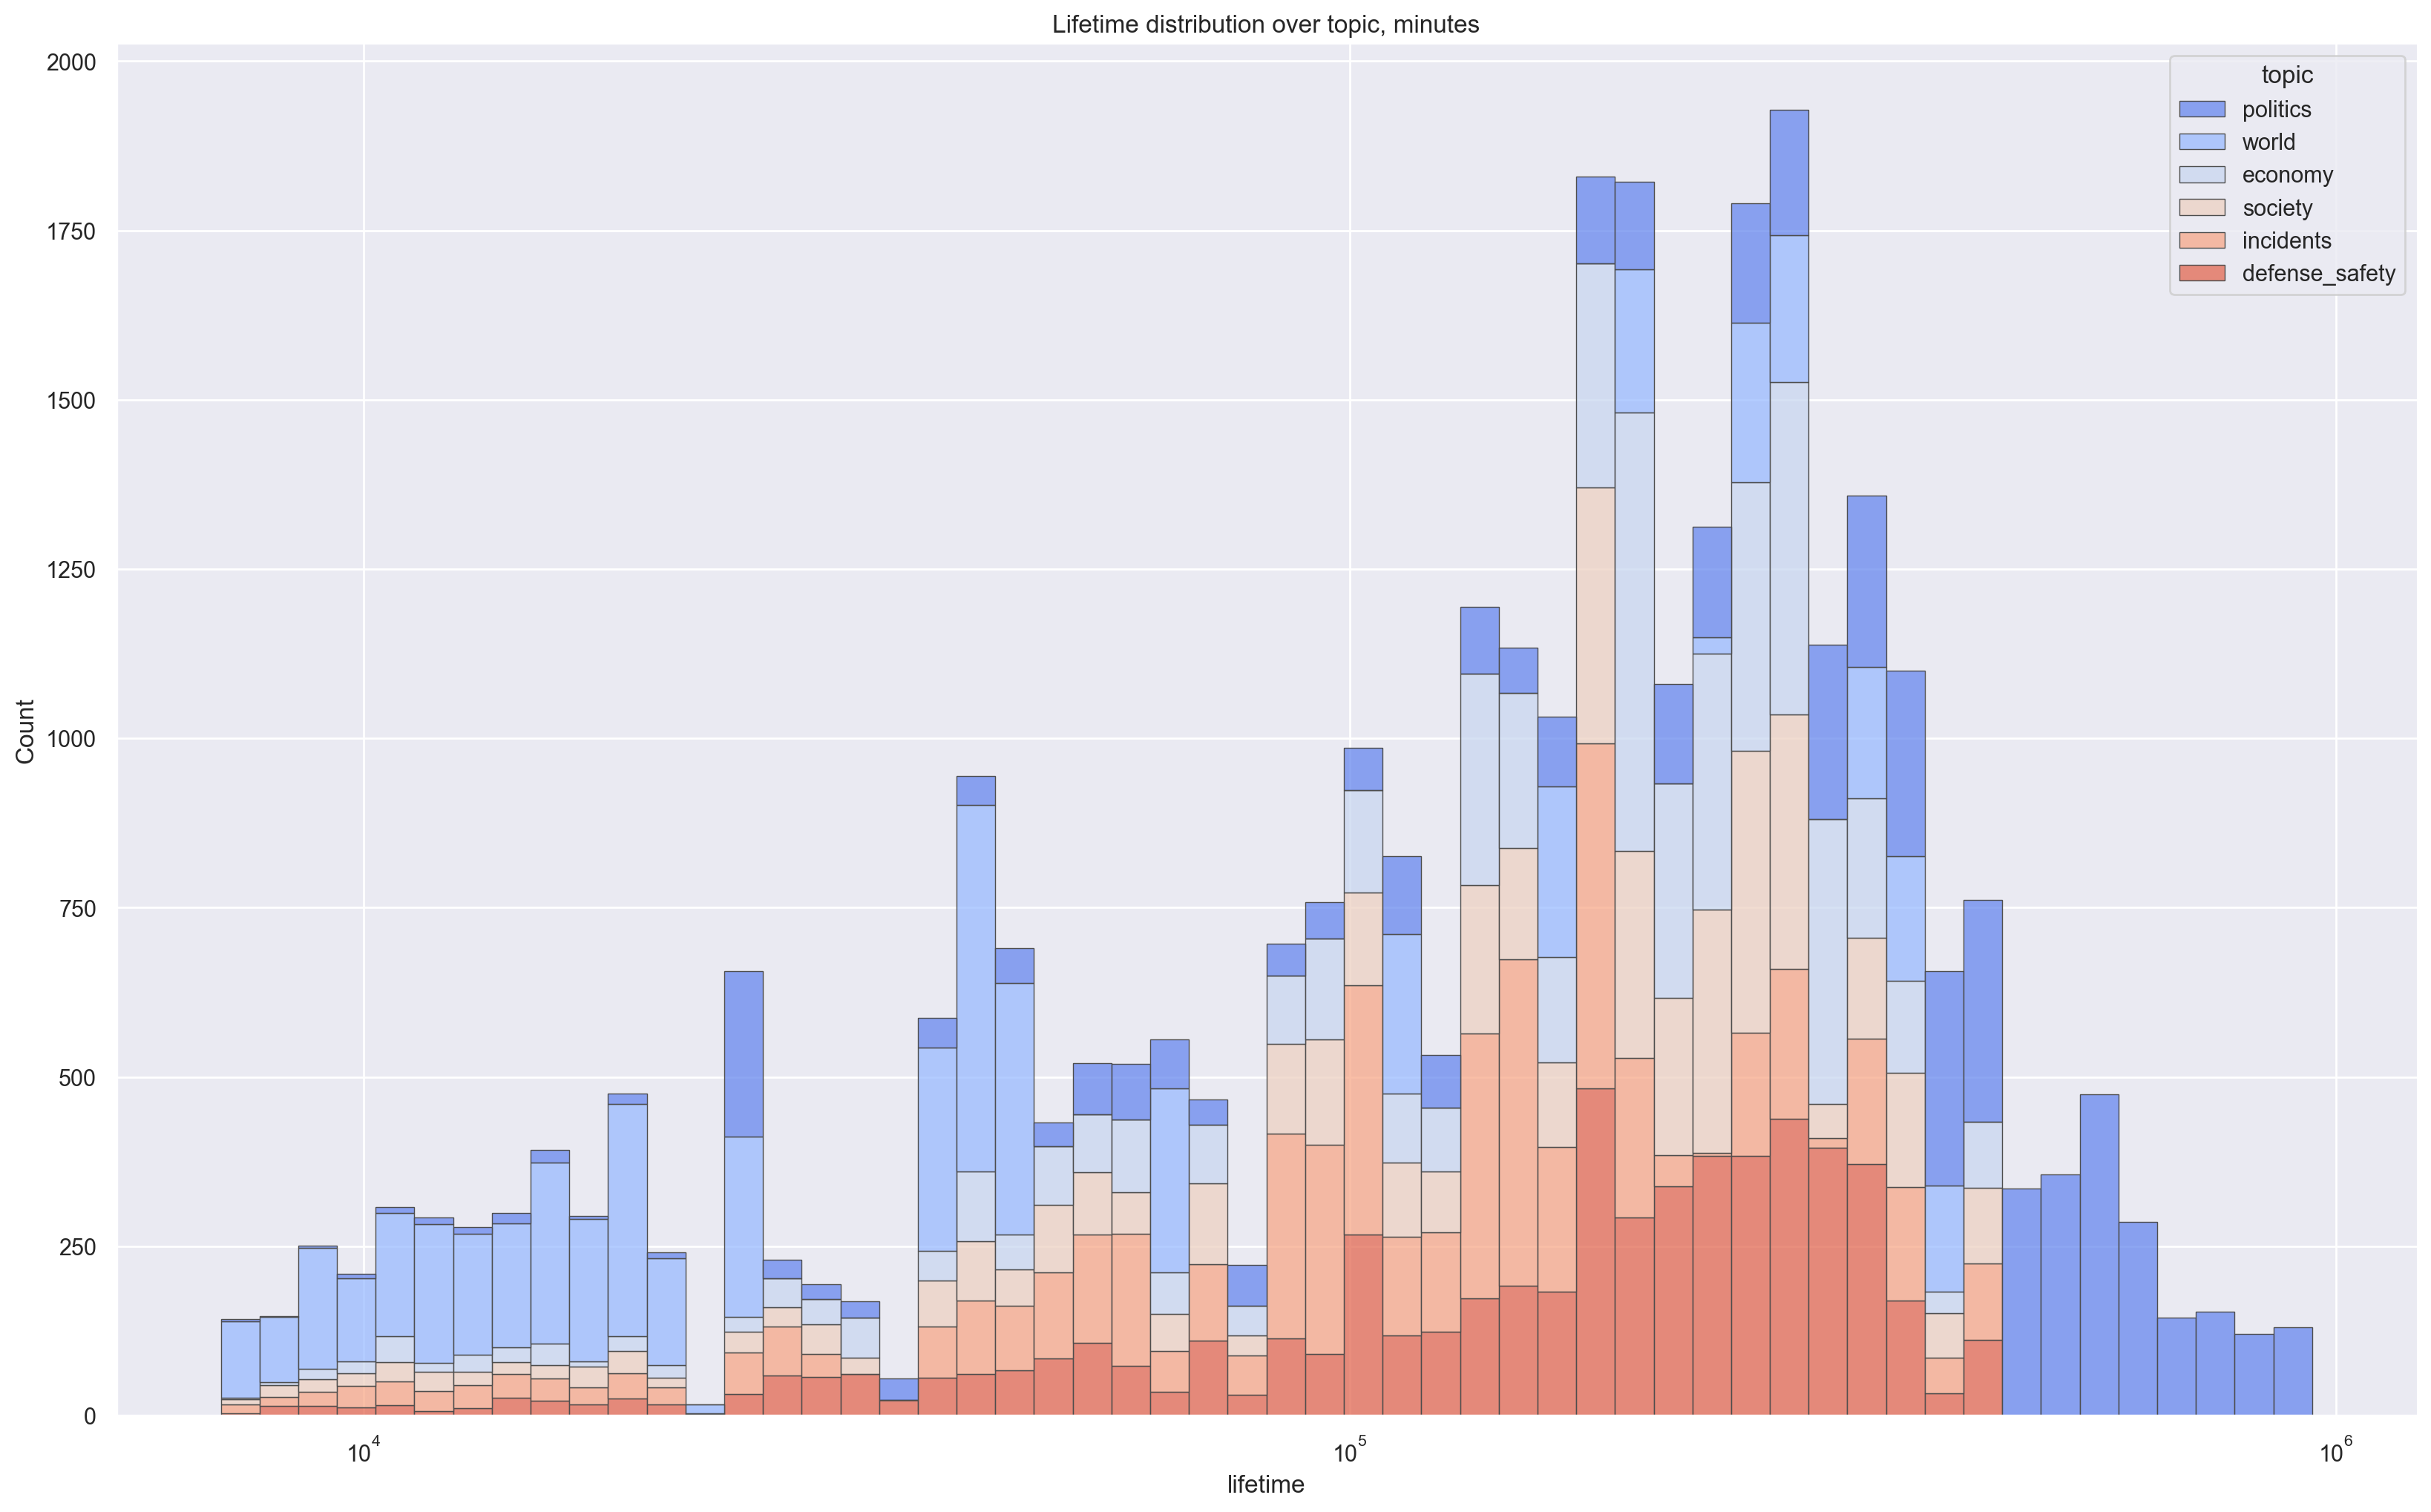

In [36]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="lifetime",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
    log_scale=True,
);
axs.set_title('Lifetime distribution over topic, minutes');

## В датасете присутствуют как старые статьи, так и новые. И само распределение имеет довольно неоднозначную форму.

In [48]:
df['views_by_minutes'] = (df['view'] + 1) / df['lifetime']

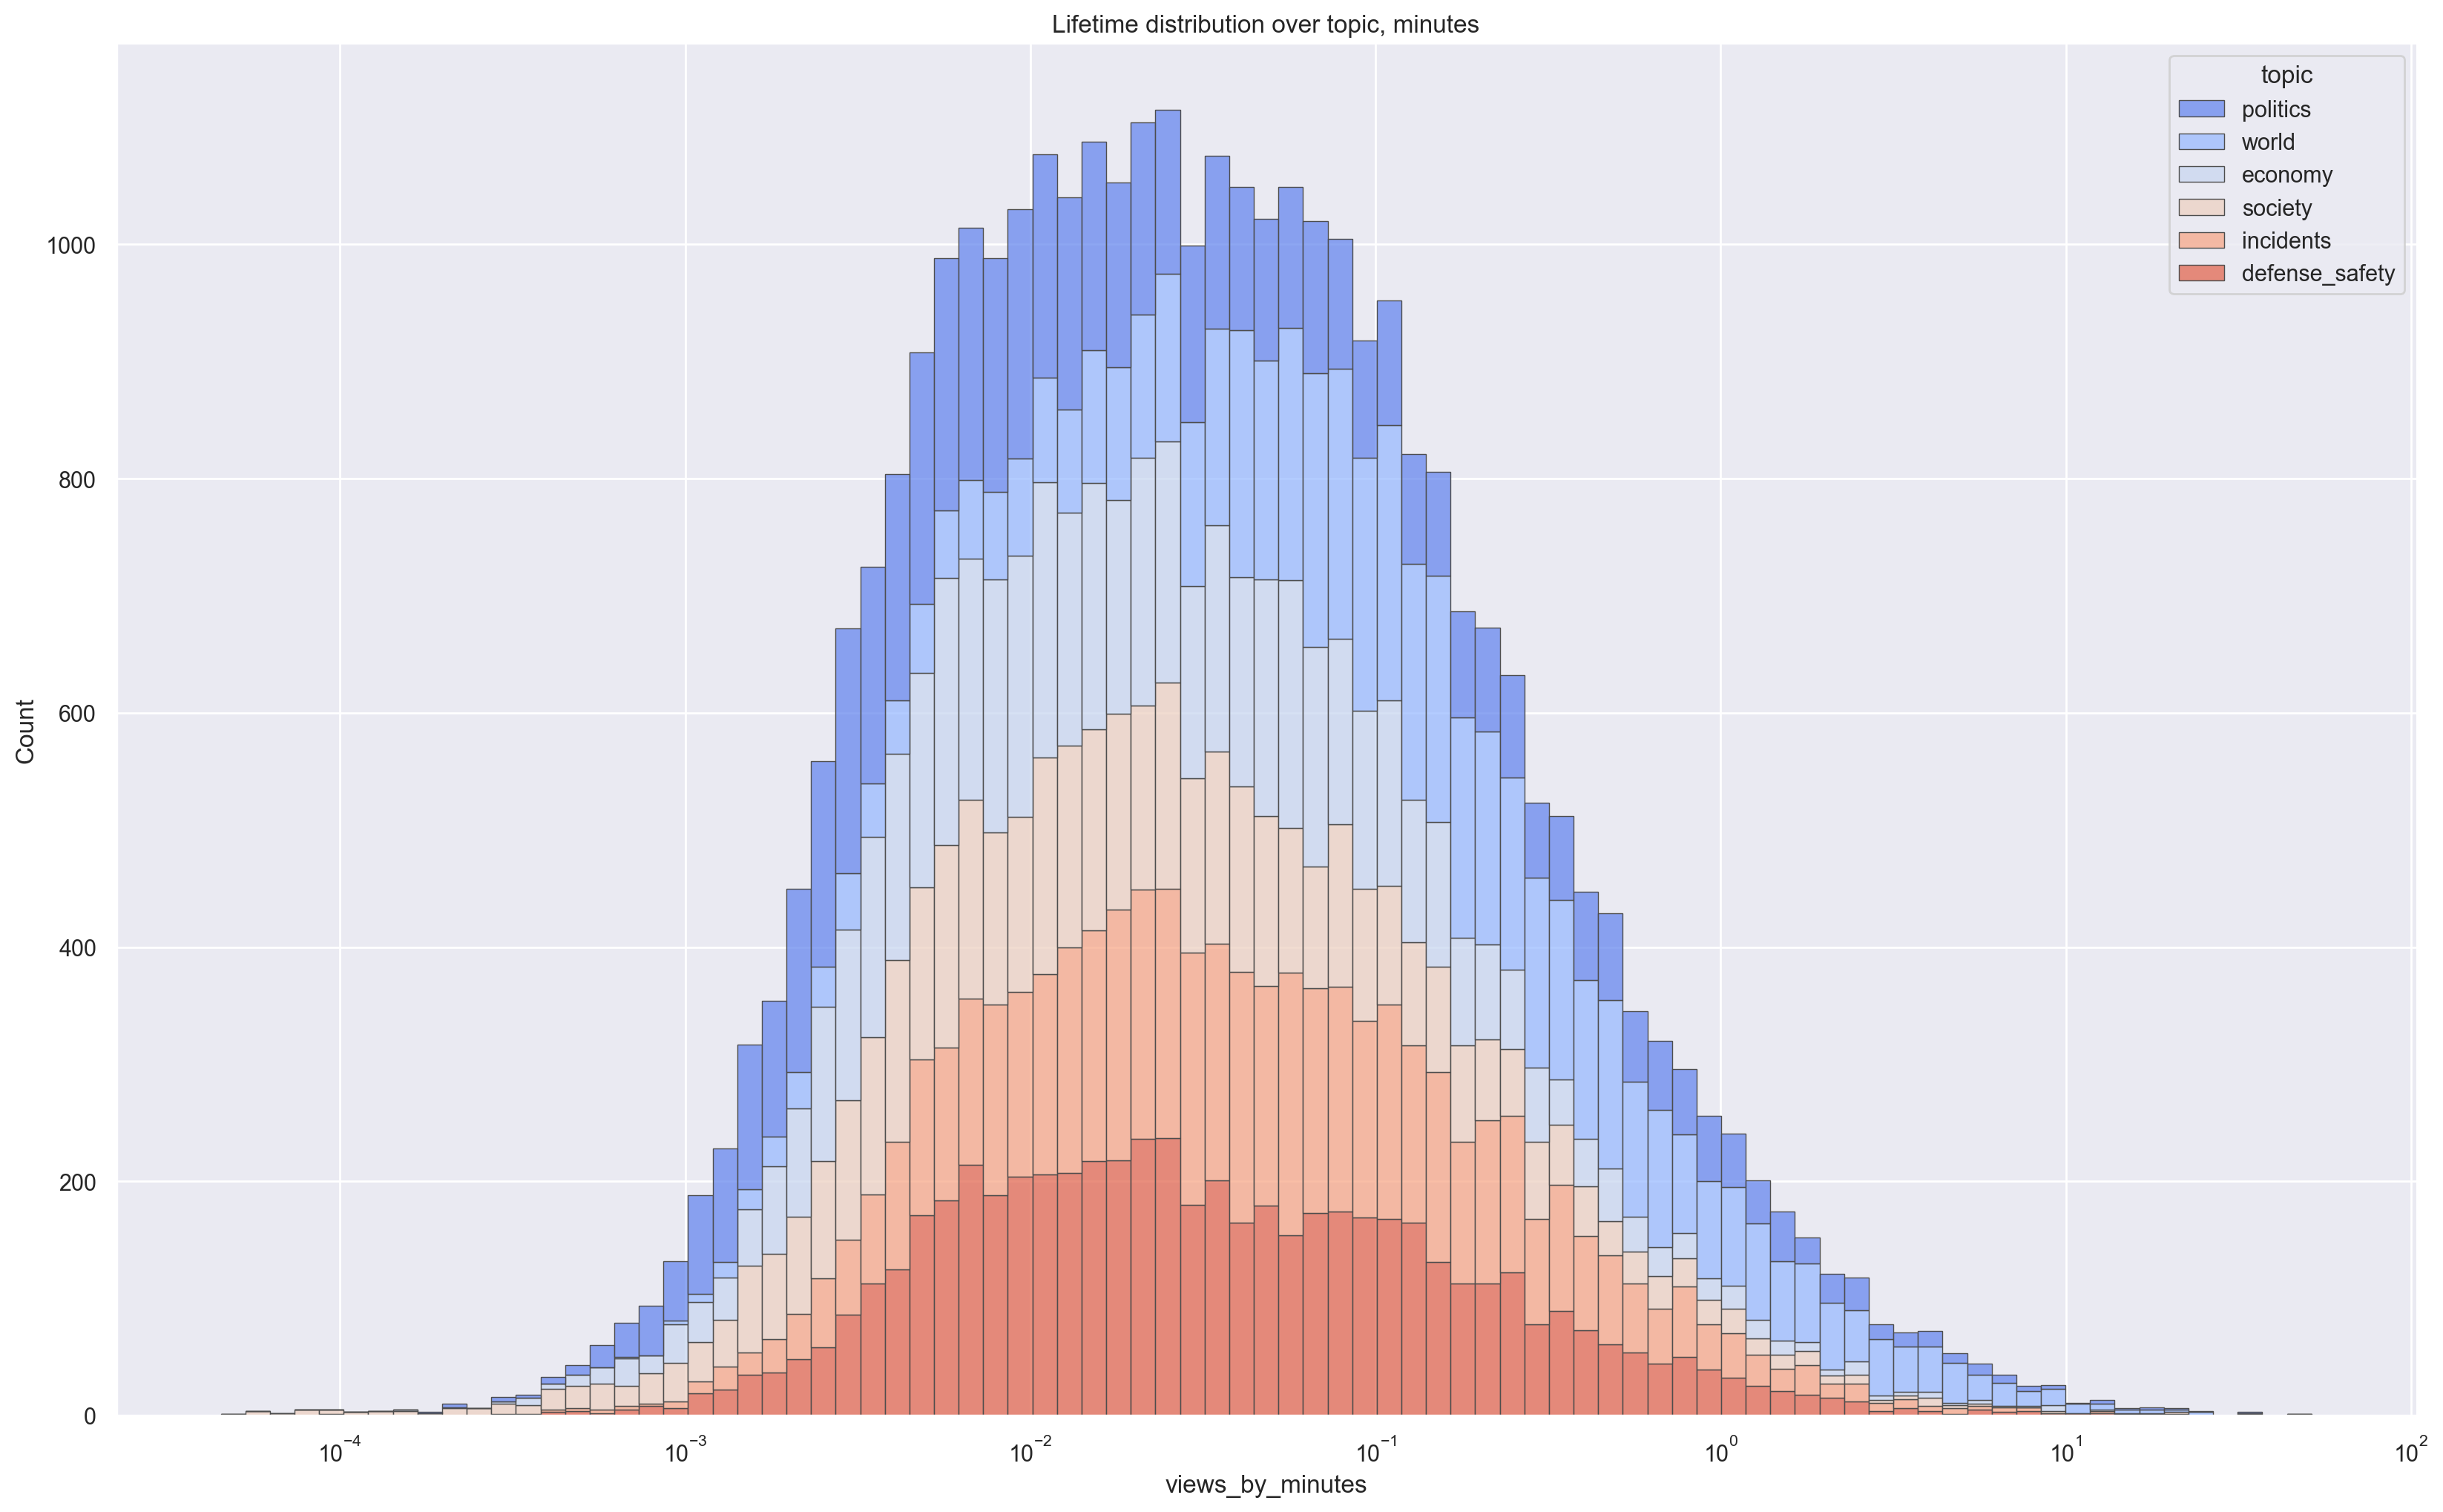

In [49]:
fig, axs = plt.subplots(1, 1, figsize=(20, 12), dpi=200)
sns.despine(fig)

sns.histplot(
    df,
    x="views_by_minutes",
    hue="topic",
    multiple="stack",
    edgecolor=".3",
    palette="coolwarm",
    linewidth=.5,
    log_scale=True,
);
axs.set_title('Lifetime distribution over topic, minutes');

In [50]:
# Генерируем выборку из нормального распределения с таким же мат. ожиданием и дисперсией, как у нашей переменной
x = np.random.normal(loc=df['views_by_minutes'].mean(), scale=df['views_by_minutes'].std(), size=100000)

# Проводим тест Манна-Уитни и получаем p-значимость
U1, p = mannwhitneyu(x, df['views_by_minutes'])

print('P-значимость:', p)

# Возьмем границу принятия решения 1%
if p < 0.01:
    print('Распределение числа просмотров в минуту можно считать нормальным')
else:
    print('Распределение числа просмотров в минуту можно считать нормальным')

P-значимость: 2.863715278472366e-12
Распределение числа просмотров в минуту можно считать нормальным


# Выводы:
- Данные распределены по топикам практически равномерно, выбивается из всех лишь топик `society`
- Практически все новости относятся к 2023 году
- Больше всего новостей публикуется в пятницу, а меньше всего в выходные дни
- Длинна заголовка новости в среднем - 65 символов, длинна второго заголовка несколько длиннее - 78-85 символов, длинна текста имеет большие выбросы по темам: политика, общество, экономика
- С числом просмотров новости в чистом виде работать невозможно, при помощи этого признака и времени публикации новости были получены два новых признака, имеющих нормальное распределение, проверенное критерием Манна-Уитни: `views_by_minutes` и `log_view`
- Ключевые слова в топиках `defense_safety` и `incidents` выделяются не так сильно как в других топиках

In [51]:
df.to_csv('data_for_nlp_clear.csv', index = False)